In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
import os
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_eq_atl")
llc_zarr = [os.path.join(out_dir, "llc.zarr"),os.path.join(out_dir, "llc_SSV.zarr")]
llc_zarr_filt = [os.path.join(out_dir, "llc_filtered.zarr"),os.path.join(out_dir, "llc_SSV_filtered.zarr")]
ds = xr.merge([xr.open_zarr(l) for l in llc_zarr]).compute()
ds_low = xr.merge([xr.open_zarr(l) for l in llc_zarr_filt]).compute()

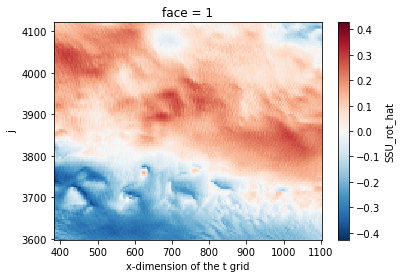

In [4]:
ds_low.SSU_rot_hat.sel(time='2012-11').mean('time').plot()

In [5]:
# Eulerian stats
root_path = '/home1/datawork/zcaspar/mit4320/'

ds_low_dl1 = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl1.0.nc'),
                       xr.open_dataset(root_path+'energy_SSV_low_binned_dl1.0.nc'),
                       xr.open_dataset(root_path+'energy_low_binned_dl1.0.nc')])

ds_low_var_dl1 = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_variance_binned_dl1.0.nc'),
                           xr.open_dataset(root_path+'energy_SSV_low_variance_binned_dl1.0.nc'),
                           xr.open_dataset(root_path+'iprime_hat_low_variance_binned_dl1.0.nc')])

ds_low_dl2 = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_low_binned_dl2.0.nc')])

In [6]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/diags/'
run_name = 'regional_eq_atl/'

#run_name_old = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'llc_parcels_lpass_filtered_05cpd' #_iprime
#'filtered_itide_Tw30_sd_band04'

df = dd.read_parquet(root_dir+run_name+parcels_index)

df.head()

trajectory        lat        lon    z  zonal_velocity  \
time                                                                
2011-11-15     6000285   6.876764 -23.395834  0.0             0.0   
2011-11-15     6000458   4.959864 -16.104166  0.0             0.0   
2011-11-15     6000427  -0.832312 -17.145834  0.0             0.0   
2011-11-15     6000441  12.559929 -17.145834  0.0             0.0   
2011-11-15     6000258   4.959864 -24.437500  0.0             0.0   

            meridional_velocity  waterdepth  zonal_velocity_hat_real  \
time                                                                   
2011-11-15                  0.0         0.0                 0.058198   
2011-11-15                  0.0         0.0                -0.019447   
2011-11-15                  0.0         0.0                -0.245828   
2011-11-15                  0.0         0.0                 0.003988   
2011-11-15                  0.0         0.0                -0.047521   

            zonal_velocity_hat_imag  meridional_velocity_hat_real  \
time                                                                
2011-11-15                      0.0                      0.138364   
2011-11-15                      0.0                      0.032680   
2011-11-15                      0.0                      0.056093   
2011-11-15                      0.0                      0.022226   
2011-11-15                      0.0                      0.056800   

            meridional_velocity_hat_imag  
time                                      
2011-11-15                           0.0  
2011-11-15                           0.0  
2011-11-15                           0.0  
2011-11-15                           0.0  
2011-11-15                           0.0

In [7]:
_ds_low = ds_low.assign_coords({'lon':ds_low.lon.mean('j'),'lat':ds_low.lat.mean('i')})
_ds_low

<xarray.Dataset>
Dimensions:      (j: 131, i: 180, time: 2880)
Coordinates:
    face         int64 1
  * i            (i) int64 384 388 392 396 400 404 ... 1084 1088 1092 1096 1100
  * j            (j) int64 3600 3604 3608 3612 3616 ... 4104 4108 4112 4116 4120
    lat          (j) float64 0.009682 0.08713 0.1646 0.242 ... 9.837 9.913 9.988
    lon          (i) float64 -29.99 -29.91 -29.82 ... -15.24 -15.16 -15.07
  * time         (time) datetime64[ns] 2011-11-15 ... 2012-11-08T21:00:00
Data variables:
    SSU_rot_hat  (j, i, time) float64 -0.2764 -0.2796 ... -0.1061 -0.1061
    SSV_rot_hat  (j, i, time) float64 -0.1109 -0.1082 -0.1054 ... 0.0466 0.0466

In [8]:
_ds = ds.assign_coords({'lon':ds.lon.mean('j'),'lat':ds.lat.mean('i')})
ds = _ds.swap_dims({'i':'lon','j':'lat'})

In [9]:
ds_low = _ds_low.swap_dims({'i':'lon','j':'lat'})

In [10]:
ds = ds.isel(time=slice(0,None,3))

In [11]:
ds_low['energy_SSU_hat'] = ds_low.SSU_rot_hat**2
ds_low['energy_SSV_hat'] = ds_low.SSV_rot_hat**2

In [12]:
v='SSU_rot'
def gen_figs(ds_low,it,v,savefig=False):
    name=v+'_%s'%it
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ds_low[v+'_hat'].isel(time=it).plot(ax=ax[1],x='lon',y='lat',vmax=0.3,vmin=-0.3,cmap='RdBu_r',
                                                        cbar_kwargs={'label':'Low pass filtered'+v})
    ds[v].isel(time=it).plot(ax=ax[0],x='lon',y='lat',vmax=0.3,vmin=-0.3,cmap='RdBu_r'
                             )#,x='lon',y='lat'
    for a in ax:
        a.set_title('Time : %s'%ds[v].isel(time=it).time.values.astype('M8[s]'))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/raw_lpass/'+name+'.jpg')
        plt.close()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/nanny.py", line 931, in _run
    loop.run_sync(run)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/home1/datahome/zcaspar/miniconda3/envs/croc

Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/dev/shm/pbs.430458.datarmor0/ipykernel_53758/2394263378.py", line 2, in <module>
    gen_figs(ds_low,it,v,savefig=True)
  File "/dev/shm/pbs.430458.datarmor0/ipykernel_53758/2543373431.py", line 13, in gen_figs
    fig.savefig('/home1/datawork/zcaspar/Figs/raw_lpass/'+name+'.jpg')
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/matplotlib/figure.py", line 2311, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 2210, in print_figure
    result = print_method(
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1639, in wrapper
    ret

TypeError: object of type 'NoneType' has no len()

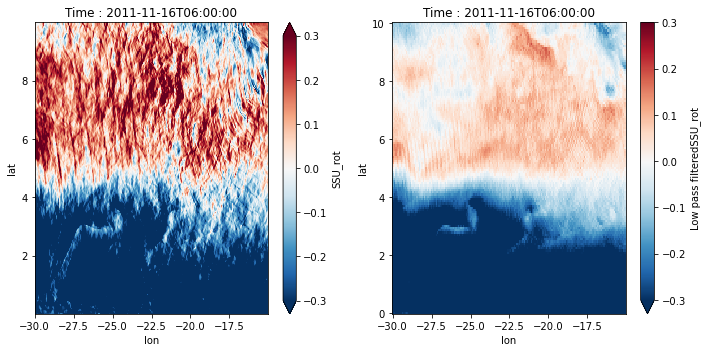

In [11]:
for it in range(0,ds_low.time.size,2):
    gen_figs(ds_low,it,v,savefig=True)

#gen_figs(ds_low,100,'SSV_rot')

In [13]:
_df = df[['trajectory','lat','lon','zonal_velocity','meridional_velocity','zonal_velocity_hat_real','meridional_velocity_hat_real']]

In [14]:
_df = _df.compute()

In [15]:
time = np.unique(_df.index)

In [16]:
_df_sub = _df.loc[time[::3]]

In [17]:
def remove_duplicates(df):
    """Find duplicates in dataframe and remove them.
    Create a column 'dt_flag', False if the dt is not different from 1/24
    
    ----------------
    Parameters
    df : dataframe from which duplicates must be removed, dataframe
    
    ----------------
    Returns
    df : input dataframe without duplicates and with new column 'dt_flag', dataframe
    """
#    df = df.reset_index().drop_duplicates('time').sort_values('time')#.set_index('time')
    df = df.drop_duplicates('time').set_index('time')
#    dt_df = df.index[1:]-df.index[:-1]
#    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df

In [18]:
_df_sub = _df_sub.reset_index().groupby('trajectory').apply(remove_duplicates)

In [19]:
_df_sub = _df_sub.drop(columns = 'trajectory').reset_index().set_index('time')

In [20]:
_df_sub['energy_SSU'] = (_df_sub.zonal_velocity_hat_real)**2
_df_sub['energy_SSV'] = (_df_sub.meridional_velocity_hat_real)**2
_df_sub['energy_SSV_tot'] = (_df_sub.meridional_velocity)**2
_df_sub['energy_SSU_tot'] = (_df_sub.zonal_velocity)**2

In [21]:
np.unique(_df_sub.index).size
print(_df_sub.index[0],_df_sub.index[-1])
print(ds_low.time[0],ds_low.time[-1])

2011-11-15 00:00:00 2012-11-09 00:00:00
<xarray.DataArray 'time' ()>
array('2011-11-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 1
    time     datetime64[ns] 2011-11-15 <xarray.DataArray 'time' ()>
array('2012-11-08T21:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 1
    time     datetime64[ns] 2012-11-08T21:00:00


In [22]:
_df_sub

trajectory       lat        lon  zonal_velocity  \
time                                                                   
2011-11-15 00:00:00     5000947 -4.132948   3.687500        0.000000   
2011-11-15 03:00:00     5000947 -4.135410   3.685934    -7637.200264   
2011-11-15 06:00:00     5000947 -4.132304   3.685960     4726.192140   
2011-11-15 09:00:00     5000947 -4.133024   3.693877     9604.564111   
2011-11-15 12:00:00     5000947 -4.135109   3.702607     9824.954393   
...                         ...       ...        ...             ...   
2012-11-08 12:00:00    46003013  6.690549 -29.110799    19119.078699   
2012-11-08 15:00:00    46003013  6.709550 -29.098698    17047.222609   
2012-11-08 18:00:00    46003013  6.741336 -29.087826     7469.963780   
2012-11-08 21:00:00    46003013  6.769865 -29.077983    22190.734293   
2012-11-09 00:00:00    46003013  6.789310 -29.064184    21027.988726   

                     meridional_velocity  zonal_velocity_hat_real  \
time                                                                
2011-11-15 00:00:00             0.000000                 0.015748   
2011-11-15 03:00:00          3794.038818                 0.019487   
2011-11-15 06:00:00          7220.634766                 0.022621   
2011-11-15 09:00:00        -10498.397461                 0.024896   
2011-11-15 12:00:00          8756.459961                 0.026122   
...                                  ...                      ...   
2012-11-08 12:00:00          9705.705078                 0.122937   
2012-11-08 15:00:00         35450.050781                 0.122948   
2012-11-08 18:00:00         34250.171875                 0.122955   
2012-11-08 21:00:00         32642.652344                 0.122959   
2012-11-09 00:00:00         20950.611328                 0.122960   

                     meridional_velocity_hat_real  energy_SSU  energy_SSV  \
time                                                                        
2011-11-15 00:00:00                      0.010585    0.000248    0.000112   
2011-11-15 03:00:00                      0.011541    0.000380    0.000133   
2011-11-15 06:00:00                      0.011278    0.000512    0.000127   
2011-11-15 09:00:00                      0.009609    0.000620    0.000092   
2011-11-15 12:00:00                      0.006454    0.000682    0.000042   
...                                           ...         ...         ...   
2012-11-08 12:00:00                     -0.108558    0.015114    0.011785   
2012-11-08 15:00:00                     -0.108546    0.015116    0.011782   
2012-11-08 18:00:00                     -0.108539    0.015118    0.011781   
2012-11-08 21:00:00                     -0.108537    0.015119    0.011780   
2012-11-09 00:00:00                     -0.108536    0.015119    0.011780   

                     energy_SSV_tot  energy_SSU_tot  
time                                                 
2011-11-15 00:00:00    0.000000e+00    0.000000e+00  
2011-11-15 03:00:00    1.439473e+07    5.832683e+07  
2011-11-15 06:00:00    5.213757e+07    2.233689e+07  
2011-11-15 09:00:00    1.102164e+08    9.224765e+07  
2011-11-15 12:00:00    7.667559e+07    9.652973e+07  
...                             ...             ...  
2012-11-08 12:00:00    9.420071e+07    3.655392e+08  
2012-11-08 15:00:00    1.256706e+09    2.906078e+08  
2012-11-08 18:00:00    1.173074e+09    5.580036e+07  
2012-11-08 21:00:00    1.065543e+09    4.924287e+08  
2012-11-09 00:00:00    4.389281e+08    4.421763e+08  

[1434798 rows x 11 columns]

In [23]:
def gen_fig_flts(ds_low,df,it,v,savefig=False):
    name=v+'_%s'%it
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ds_low[v+'_hat'].isel(time=it).plot(ax=ax,x='lon',y='lat',vmax=0.3,vmin=-0.3,cmap='RdBu_r',
                                                        cbar_kwargs={'label':'Low pass filtered'+v})
    time = np.unique(df.index)
    _df = df.loc[time[it]]
    ax.scatter(_df.lon,_df.lat)
#    ax.scatter(df_id.lon,df_id.lat)
    ax.set_xlim(ds_low.lon.min(),ds_low.lon.max());ax.set_ylim(ds_low.lat.min(),ds_low.lat.max())
    ax.set_title('Time : %s'%ds_low.isel(time=it).time.values.astype('M8[s]'))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/flts_lpass/'+name+'.jpg')
        plt.close()

In [24]:
time_sub = np.unique(_df_sub.index)

In [25]:
traj0 = _df_sub.loc[time_sub[0]]["trajectory"]

In [26]:
df_sub0 = _df_sub[_df_sub.trajectory.isin(traj0)]

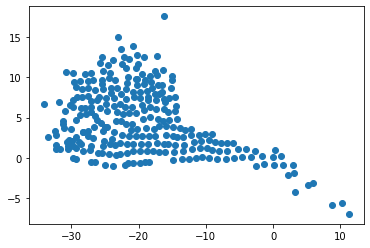

In [27]:
plt.scatter(_df_sub.loc[time_sub[100]].lon,_df_sub.loc[time_sub[100]].lat)

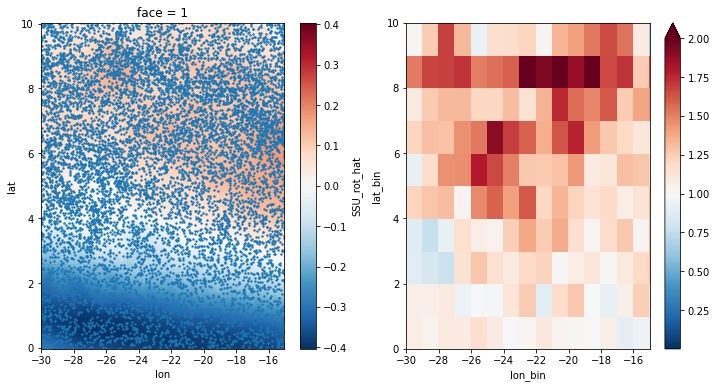

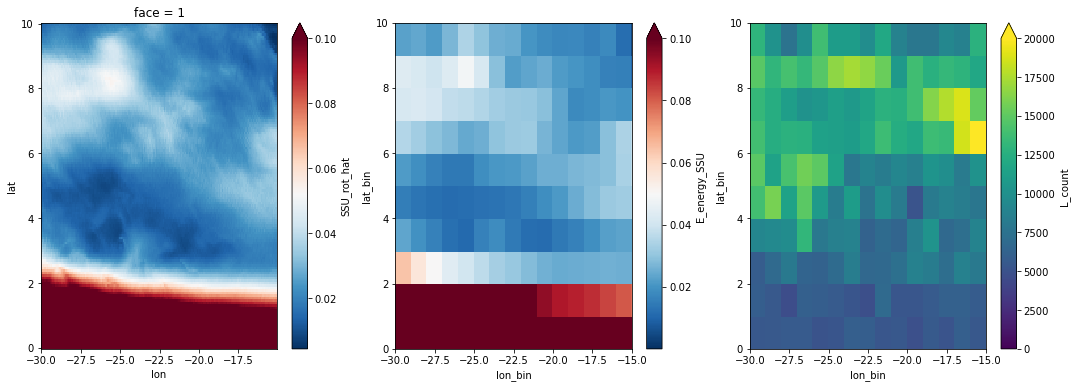

In [28]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ds_low.SSU_rot_hat.mean('time').plot(ax=ax[0],x='lon',y='lat',cmap='RdBu_r')
ax[0].scatter(_df_sub.lon[::50],_df_sub[::50].lat,s=2)
(ds_low_dl1.L_energy_SSU/ds_low_dl1.E_energy_SSU).plot(ax=ax[1],xlim=(-30,-15),ylim=(0,10),y='lat_bin',cmap='RdBu_r',vmax=2)
fig,ax = plt.subplots(1,3,figsize=(18,6))
ds_low_dl1.E_energy_SSU.plot(ax=ax[1],xlim=(-30,-15),ylim=(0,10),y='lat_bin',cmap='RdBu_r',vmax=0.1)
((ds_low.SSU_rot_hat)**2).mean('time').plot(ax=ax[0],x='lon',y='lat',cmap='RdBu_r',vmax=0.1)
ds_low_dl1.L_count.plot(ax=ax[2],xlim=(-30,-15),ylim=(0,10),y='lat_bin',vmax=20000)

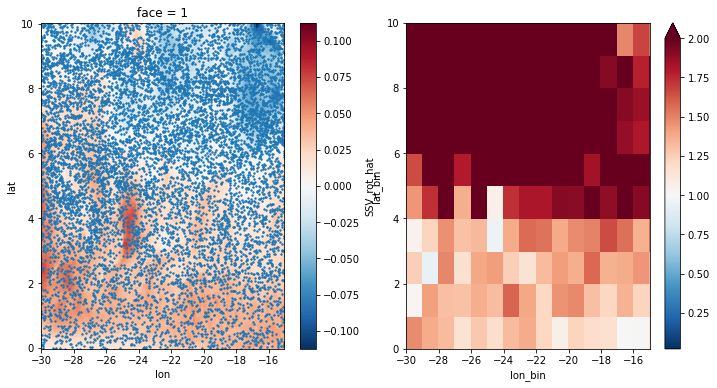

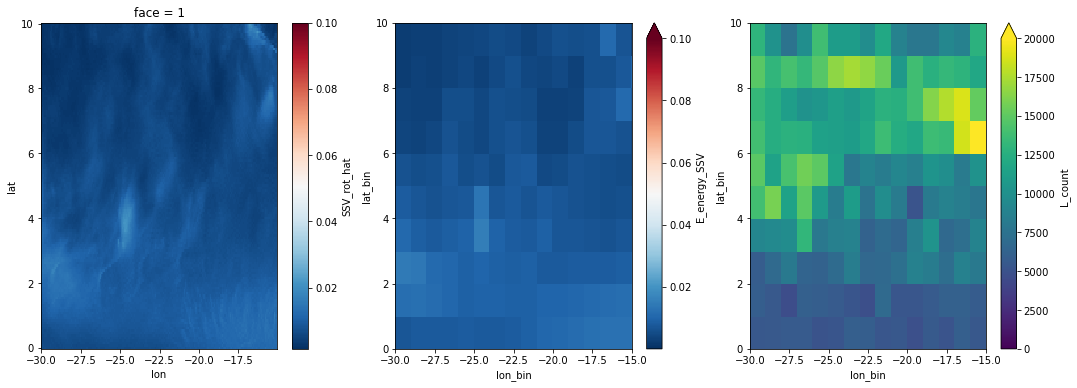

In [29]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ds_low.SSV_rot_hat.mean('time').plot(ax=ax[0],x='lon',y='lat',cmap='RdBu_r')
ax[0].scatter(_df_sub.lon[::50],_df_sub[::50].lat,s=2)
(ds_low_dl1.L_energy_SSV/ds_low_dl1.E_energy_SSV).plot(ax=ax[1],xlim=(-30,-15),ylim=(0,10),y='lat_bin',cmap='RdBu_r',vmax=2)
fig,ax = plt.subplots(1,3,figsize=(18,6))
ds_low_dl1.E_energy_SSV.plot(ax=ax[1],xlim=(-30,-15),ylim=(0,10),y='lat_bin',cmap='RdBu_r',vmax=0.1)
((ds_low.SSV_rot_hat)**2).mean('time').plot(ax=ax[0],x='lon',y='lat',cmap='RdBu_r',vmax=0.1)
ds_low_dl1.L_count.plot(ax=ax[2],xlim=(-30,-15),ylim=(0,10),y='lat_bin',vmax=20000)

In [30]:
print(ds_low_dl1.sel(lon_bin=-23.5,lat_bin=0.5).E_energy_SSU,ds_low_dl1.sel(lon_bin=-23.5,lat_bin=0.5).L_energy_SSU)

<xarray.DataArray 'E_energy_SSU' ()>
array(0.175416)
Coordinates:
    lon_bin  float64 -23.5
    lat_bin  float64 0.5 <xarray.DataArray 'L_energy_SSU' ()>
array(0.17308)
Coordinates:
    lon_bin  float64 -23.5
    lat_bin  float64 0.5


In [56]:
dsi = ds_low_dl1.sel(lon_bin=-18.5,lat_bin=8.5)
dsi_low = ds_low.sel(lon=slice(-19,-18),lat=slice(8,9))

dsi_1 = ds_low_dl1.sel(lon_bin=-20.5,lat_bin=.5)
dsi_low_1 = ds_low.sel(lon=slice(-21,-20),lat=slice(0,1))

In [119]:
dl = 1
lon_bins = np.arange(-30.,-14., dl)
lat_bins = np.arange(0, 11, dl)

def binning(_df,binsize):
    #lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    _df['lon_cut'] = pd.cut(_df['lon'], bins=lon_bins)
    _df['lat_cut'] = pd.cut(_df['lat'],bins=lat_bins)
    _df = _df.drop(columns=['lon','lat','trajectory']) # ,'h'
    return _df
_df = binning(_df_sub,dl)
_df0 = binning(df_sub0,dl)

/dev/shm/pbs.441390.datarmor0/ipykernel_48676/1791386964.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['lon_cut'] = pd.cut(_df['lon'], bins=lon_bins)
/dev/shm/pbs.441390.datarmor0/ipykernel_48676/1791386964.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['lat_cut'] = pd.cut(_df['lat'],bins=lat_bins)


In [120]:
def mean_binned(df,v):
    nb_pts = df.groupby(['lon_cut','lat_cut']).mean()[v]
    nb_pts = nb_pts.reset_index()
    nb_pts['lon_bin'] = nb_pts.lon_cut.apply(lambda x :x.mid)
    nb_pts['lat_bin'] = nb_pts.lat_cut.apply(lambda x :x.mid)
    nb_pts = nb_pts.drop(columns=['lon_cut','lat_cut'])
    ds_nb = nb_pts.set_index(['lon_bin','lat_bin']).to_xarray().unstack()
    return ds_nb

In [59]:
dsi_low_dl1 = ds_low_dl1.sel(lon_bin=slice(-30,-15),lat_bin=slice(0,10))

In [131]:
ds_low_sub = ds_low.sel(time=slice('2012-05','2012-09'))

In [132]:
ds_low_sub

<xarray.Dataset>
Dimensions:         (lat: 131, lon: 180, time: 1224)
Coordinates:
    face            int64 1
    i               (lon) int64 384 388 392 396 400 ... 1084 1088 1092 1096 1100
    j               (lat) int64 3600 3604 3608 3612 3616 ... 4108 4112 4116 4120
  * lat             (lat) float64 0.009682 0.08713 0.1646 ... 9.837 9.913 9.988
  * lon             (lon) float64 -29.99 -29.91 -29.82 ... -15.24 -15.16 -15.07
  * time            (time) datetime64[ns] 2012-05-01 ... 2012-09-30T21:00:00
Data variables:
    SSU_rot_hat     (lat, lon, time) float64 -0.2475 -0.2441 ... -0.05356
    SSV_rot_hat     (lat, lon, time) float64 -0.09302 -0.09521 ... 0.1086 0.1091
    energy_SSU_hat  (lat, lon, time) float64 0.06127 0.05956 ... 0.002869
    energy_SSV_hat  (lat, lon, time) float64 0.008652 0.009065 ... 0.01191

In [167]:
def binned_month(ds,df,month,v):
    _f,_s = get_month(ds,df,month)
    N = histogram(_s.lon.rename('lon'), _s.lat.rename('lat'), 
                  bins=[lon_bins,lat_bins], dim=['lon', 'lat']
                 ).persist()
    ds_binned = (histogram(_s.lon.rename('lon'), _s.lat.rename('lat'),bins=[lon_bins, lat_bins],
                       weights=_s[v+'_hat'],dim=['lon','lat']
                       )).persist()
    ds_binned = ds_binned/N
    df_mean = mean_binned(_f,v)
    ds_mean = ds_binned.mean('time')
    return df_mean,ds_mean

In [133]:
N = histogram(ds_low_sub.lon.rename('lon'), ds_low_sub.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['lon', 'lat']
             ).persist()

In [134]:
ds_binned = (histogram(ds_low_sub.lon.rename('lon'), ds_low_sub.lat.rename('lat'),bins=[lon_bins, lat_bins],
                       weights=ds_low_sub['energy_SSU_hat'],dim=['lon','lat']
                       )).persist()

In [135]:
ds_binned = ds_binned/N

In [136]:
df_mean = mean_binned(_df.loc['2012-05-01 00:00:00':'2012-09-30 00:00:00'],'energy_SSU')

In [127]:
ds_binned.mean('time')

<xarray.DataArray 'histogram_lon_lat' (lon_bin: 15, lat_bin: 10)>
array([[0.14413034, 0.15173396, 0.07237237, 0.02550173, 0.01109794,
        0.0162718 , 0.0155133 , 0.00672034, 0.00558995, 0.00591443],
       [0.16064003, 0.15665418, 0.06282048, 0.0216513 , 0.00995648,
        0.01609921, 0.01210885, 0.00572779, 0.00533677, 0.00373742],
       [0.17788348, 0.16181038, 0.05879337, 0.01855336, 0.01056799,
        0.01326326, 0.00848799, 0.00542075, 0.00319989, 0.00198529],
       [0.18760205, 0.15726388, 0.05737511, 0.01706904, 0.01167148,
        0.0109578 , 0.0075276 , 0.00414167, 0.00168603, 0.00238195],
       [0.18823041, 0.14194184, 0.05197086, 0.01695997, 0.01249541,
        0.00796172, 0.007915  , 0.00457927, 0.00169381, 0.0026421 ],
       [0.18831995, 0.12989924, 0.04812718, 0.02645887, 0.01306874,
        0.01031576, 0.00758494, 0.0046848 , 0.00181183, 0.00405527],
       [0.18576447, 0.12083193, 0.04084418, 0.03265759, 0.01249169,
        0.00962161, 0.00545554, 0.00382835, 0.00209   , 0.00308616],
       [0.18245192, 0.11956218, 0.03634162, 0.02454395, 0.0111505 ,
        0.00844494, 0.00392768, 0.00310508, 0.00310048, 0.00393034],
       [0.17717586, 0.11341305, 0.03758108, 0.01939845, 0.01250421,
        0.00810993, 0.00320931, 0.00226481, 0.00281286, 0.00457851],
       [0.17029339, 0.10172764, 0.03334301, 0.01565761, 0.0138629 ,
        0.00785972, 0.00362458, 0.00268707, 0.00302169, 0.00402065],
       [0.16202698, 0.09305515, 0.03191384, 0.01766958, 0.01275501,
        0.00933144, 0.00551   , 0.00354631, 0.00425094, 0.00346586],
       [0.15417768, 0.08812953, 0.03218933, 0.01702537, 0.0143906 ,
        0.01121163, 0.00694531, 0.00550289, 0.00635553, 0.00329373],
       [0.14771206, 0.08256596, 0.03138229, 0.01702785, 0.01538701,
        0.01216822, 0.009915  , 0.0104002 , 0.01051971, 0.00457067],
       [0.14470267, 0.07736022, 0.03035135, 0.01852668, 0.01711868,
        0.01815644, 0.01817375, 0.01437695, 0.0086063 , 0.00666299],
       [0.13955983, 0.07361778, 0.02921844, 0.01865719, 0.01886507,
        0.02091973, 0.02135561, 0.01364609, 0.00980808, 0.00611851]])
Coordinates:
  * lon_bin  (lon_bin) float64 -29.5 -28.5 -27.5 -26.5 ... -17.5 -16.5 -15.5
  * lat_bin  (lat_bin) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5

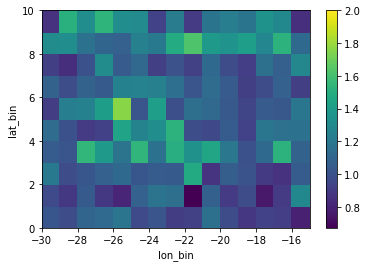

In [137]:
(df_mean.energy_SSU/ds_binned.mean('time')).plot(y='lat_bin',vmax=2)

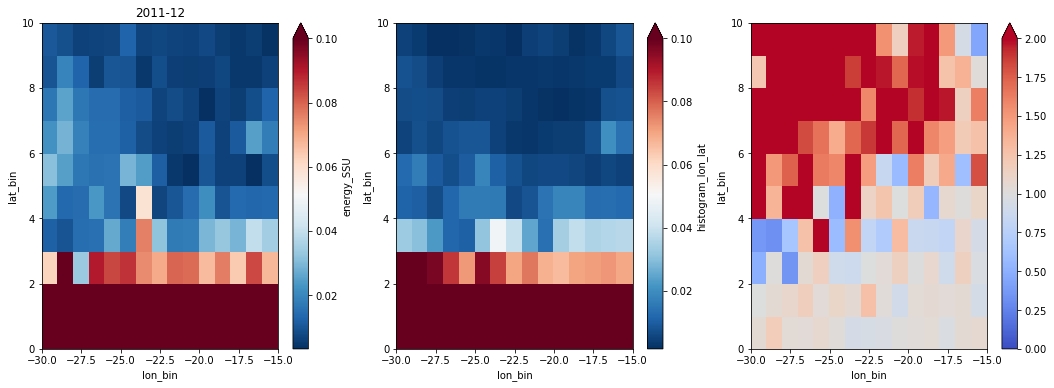

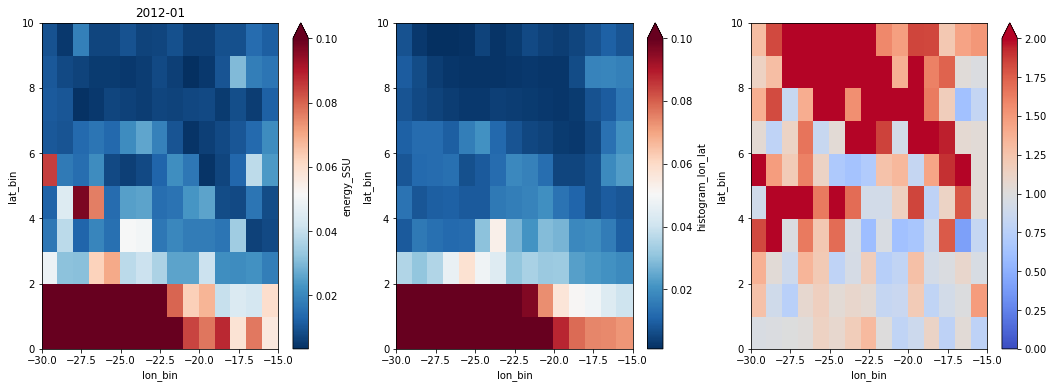

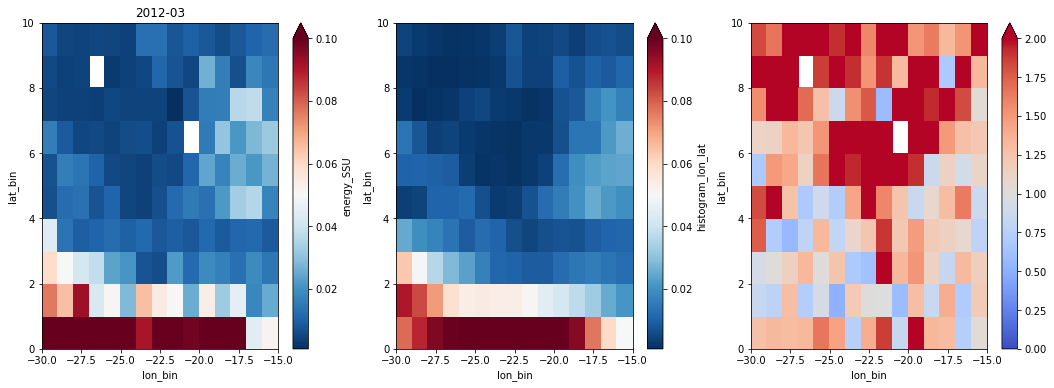

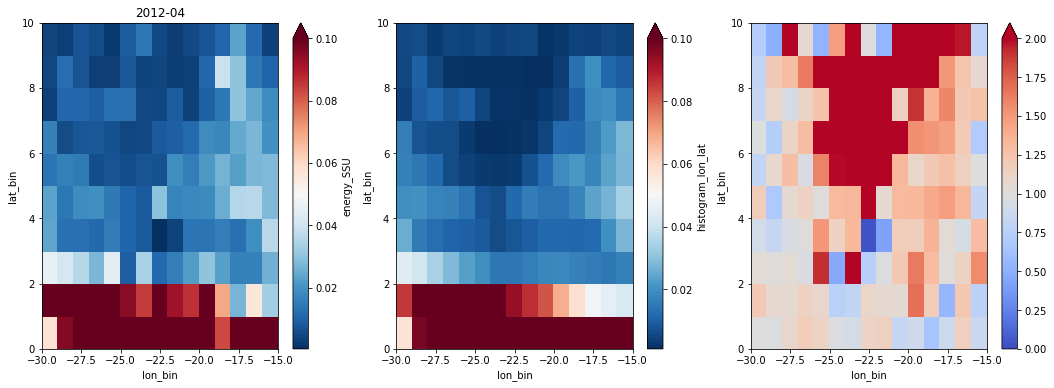

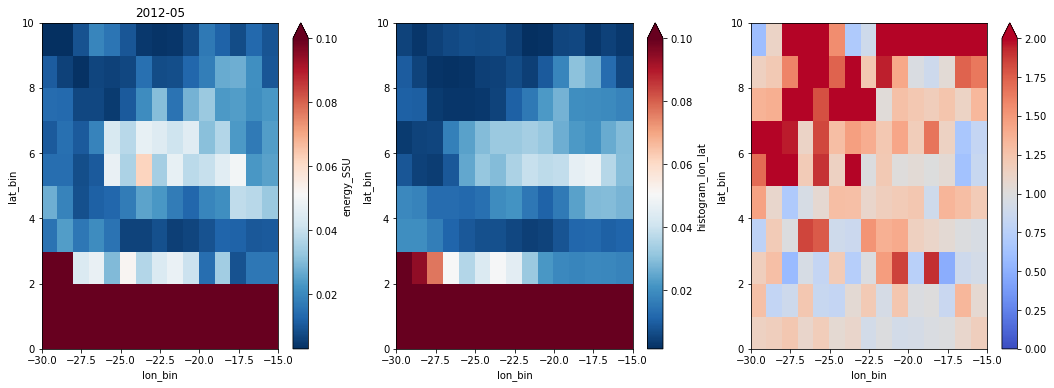

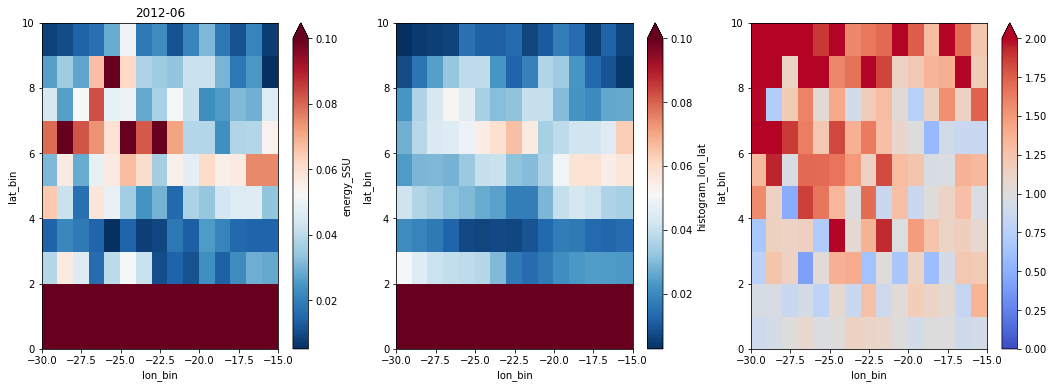

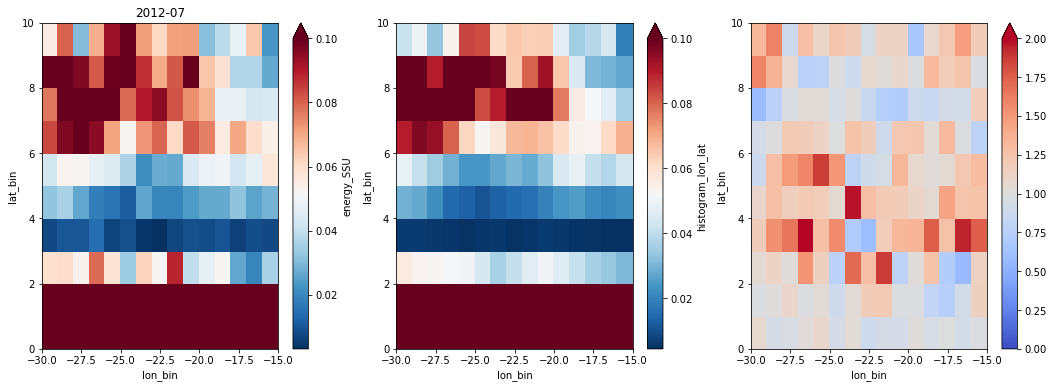

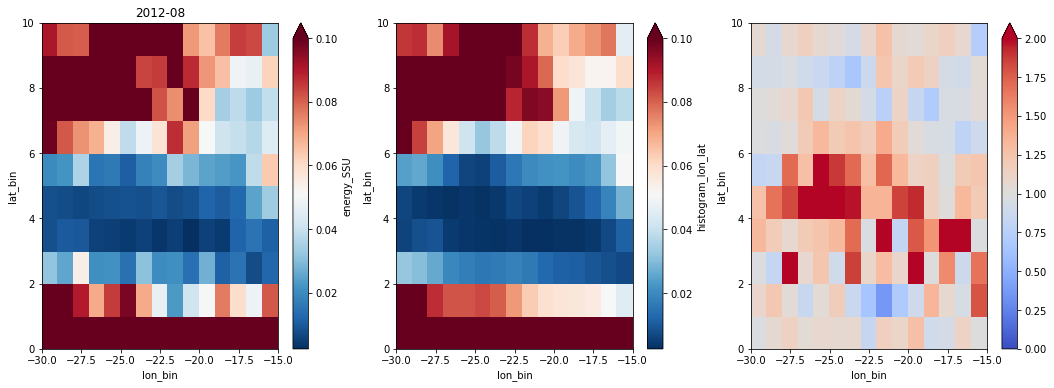

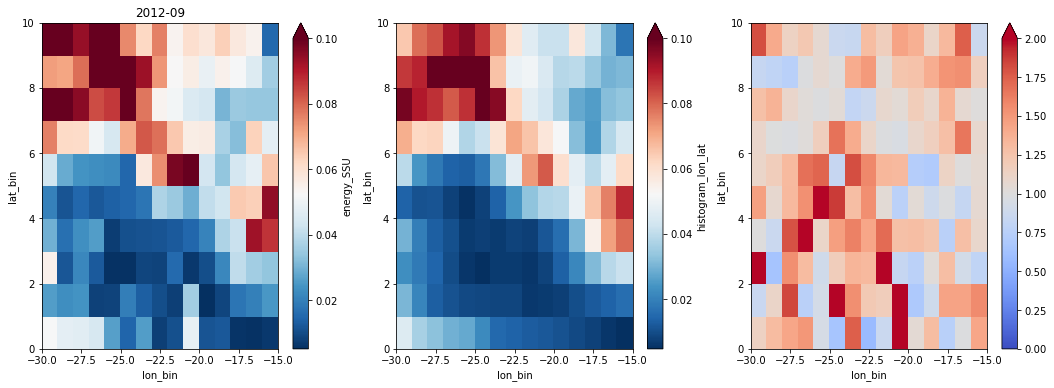

In [161]:
for i in ['2011-12','2012-01','2012-03','2012-04','2012-05','2012-06','2012-07','2012-08','2012-09']:
    df_mean, ds_mean = binned_month(ds_low,_df,i,'energy_SSU')
    fig, ax = plt.subplots(1,3,figsize=(18,6))
    df_mean.energy_SSU.plot(y='lat_bin',ax=ax[0],cmap='RdBu_r',vmax=0.1)
    ds_mean.plot(y='lat_bin',ax=ax[1],cmap='RdBu_r',vmax=0.1)
    (df_mean.energy_SSU/ds_mean).plot(y='lat_bin',ax=ax[2],cmap='coolwarm',vmax=2,vmin=0)
    ax[0].set_title(i)

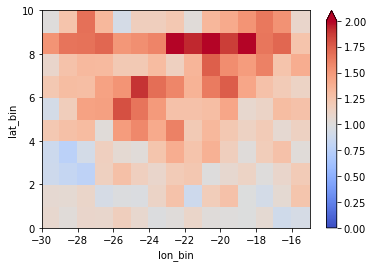

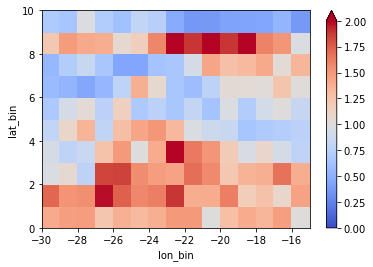

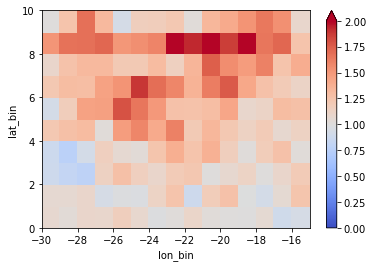

In [84]:
(mean_binned(_df_sub,'energy_SSU').energy_SSU/dsi_low_dl1.E_energy_SSU).plot(y='lat_bin',cmap='coolwarm',vmax=2,vmin=0)
plt.figure()
(mean_binned(df_sub0,'energy_SSU').energy_SSU/(dsi_low_dl1.E_energy_SSU)).plot(y='lat_bin',cmap='coolwarm',vmax=2,vmin=0)
plt.figure()
(dsi_low_dl1.L_energy_SSU/(dsi_low_dl1.E_energy_SSU)).plot(y='lat_bin',cmap='coolwarm',vmax=2,vmin=0)

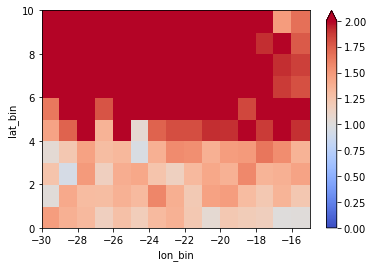

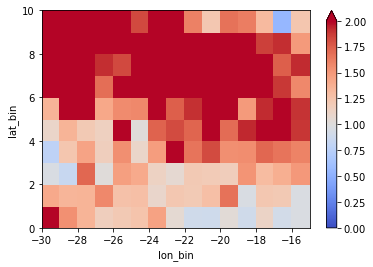

In [41]:
(mean_binned(_df_sub,'energy_SSV').energy_SSV/dsi_low_dl1.E_energy_SSV).plot(y='lat_bin',cmap='coolwarm',vmax=2,vmin=0)
plt.figure()
(mean_binned(df_sub0,'energy_SSV').energy_SSV/(dsi_low_dl1.E_energy_SSV)).plot(y='lat_bin',cmap='coolwarm',vmax=2,vmin=0)

In [162]:
dl = 0.1
lon_bins = np.arange(-30.,-15.1, dl)
lat_bins = np.arange(0, 10.1, dl)

def binning(_df,binsize):
    #lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    _df['lon_cut'] = pd.cut(_df['lon'], bins=lon_bins)
    _df['lat_cut'] = pd.cut(_df['lat'],bins=lat_bins)
    _df = _df.drop(columns=['lon','lat','trajectory']) # ,'h'
    return _df
_df = binning(_df_sub,dl)
_df0 = binning(df_sub0,dl)

/dev/shm/pbs.441390.datarmor0/ipykernel_48676/1112437249.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['lon_cut'] = pd.cut(_df['lon'], bins=lon_bins)
/dev/shm/pbs.441390.datarmor0/ipykernel_48676/1112437249.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['lat_cut'] = pd.cut(_df['lat'],bins=lat_bins)


In [163]:
def nb_month(df):
    nb_pts = df.groupby(['lon_cut','lat_cut']).count().zonal_velocity
    nb_pts = nb_pts.reset_index()
    nb_pts['lon_bin'] = nb_pts.lon_cut.apply(lambda x :x.mid)
    nb_pts['lat_bin'] = nb_pts.lat_cut.apply(lambda x :x.mid)
    nb_pts = nb_pts.drop(columns=['lon_cut','lat_cut'])
    ds_nb = nb_pts.set_index(['lon_bin','lat_bin']).to_xarray().unstack()
    return ds_nb

In [164]:
def get_month(ds,df,month):
#    date0 = month+'-01 00:00:00'
#    date1 = month+'-28 00:00:00'
    try:
        df_month = df.groupby(pd.Grouper(freq='M')).get_group(month+'-31 00:00:00')
    except :
        df_month = df.groupby(pd.Grouper(freq='M')).get_group(month+'-30 00:00:00')
    ds_month = ds.sel(time=month)
    return df_month,ds_month

In [63]:
nb_pts = _df.groupby(['lon_cut','lat_cut']).count().zonal_velocity

In [64]:
nb_pts = nb_pts.reset_index()
nb_pts['lon_bin'] = nb_pts.lon_cut.apply(lambda x :x.mid)
nb_pts['lat_bin'] = nb_pts.lat_cut.apply(lambda x :x.mid)
nb_pts = nb_pts.drop(columns=['lon_cut','lat_cut'])

In [65]:
ds_nb = nb_pts.set_index(['lon_bin','lat_bin']).to_xarray().unstack()

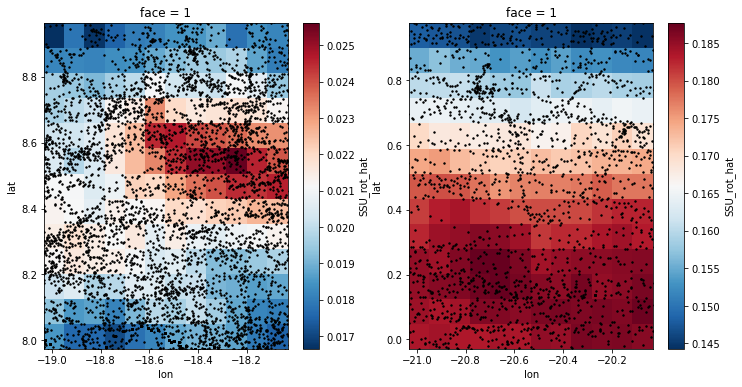

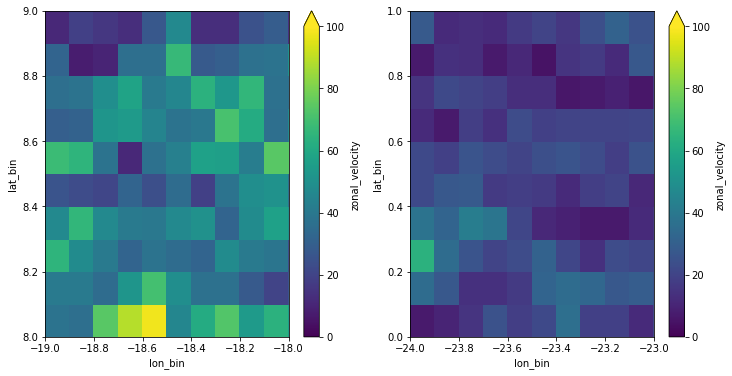

In [66]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
((dsi_low.SSU_rot_hat)**2).mean('time').plot(ax=ax[0],cmap='RdBu_r')
ax[0].scatter(_df_sub.lon,_df_sub.lat,s=2,c='k')
((dsi_low_1.SSU_rot_hat)**2).mean('time').plot(ax=ax[1],cmap='RdBu_r')
ax[1].scatter(_df_sub.lon,_df_sub.lat,s=2,c='k')

fig,ax = plt.subplots(1,2,figsize=(12,6))
ds_nb.zonal_velocity.plot(ax=ax[0],vmax=100,y='lat_bin',xlim=(-19,-18),ylim=(8,9))
ds_nb.zonal_velocity.plot(ax=ax[1],vmax=100,y='lat_bin',xlim=(-24,-23),ylim=(0,1))

In [67]:
month0 = _df_sub.groupby(pd.Grouper(freq='M')).get_group('2012-01-31 00:00:00')
month1 = _df_sub.groupby(pd.Grouper(freq='M')).get_group('2012-08-31 00:00:00')

In [68]:
ds_low_month0 = dsi_low.sel(time=slice('2012-01-01 00:00:00','2012-01-31 00:00:00'))
ds_low_month1 = dsi_low.sel(time=slice('2012-08-01 00:00:00','2012-08-31 00:00:00'))

ds1_low_month0 = dsi_low_1.sel(time=slice('2012-01-01 00:00:00','2012-01-31 00:00:00'))
ds1_low_month1 = dsi_low_1.sel(time=slice('2012-08-01 00:00:00','2012-08-31 00:00:00'))

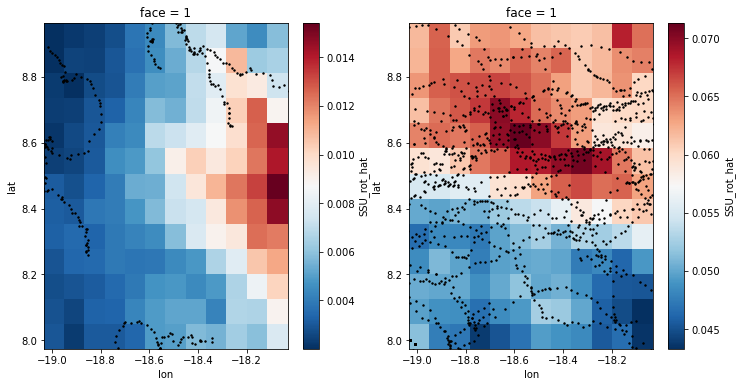

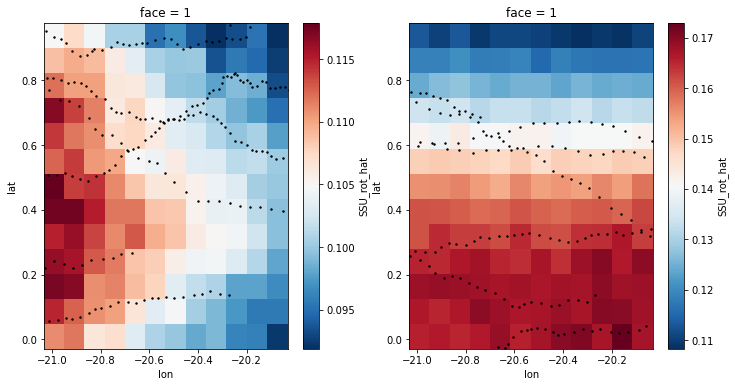

In [69]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
((ds_low_month0.SSU_rot_hat)**2).mean('time').plot(ax=ax[0],cmap='RdBu_r')
ax[0].scatter(month0.lon,month0.lat,s=2,c='k')
((ds_low_month1.SSU_rot_hat)**2).mean('time').plot(ax=ax[1],cmap='RdBu_r')
ax[1].scatter(month1.lon,month1.lat,s=2,c='k')

fig,ax = plt.subplots(1,2,figsize=(12,6))
((ds1_low_month0.SSU_rot_hat)**2).mean('time').plot(ax=ax[0],cmap='RdBu_r')
ax[0].scatter(month0.lon,month0.lat,s=2,c='k')
((ds1_low_month1.SSU_rot_hat)**2).mean('time').plot(ax=ax[1],cmap='RdBu_r')
ax[1].scatter(month1.lon,month1.lat,s=2,c='k')


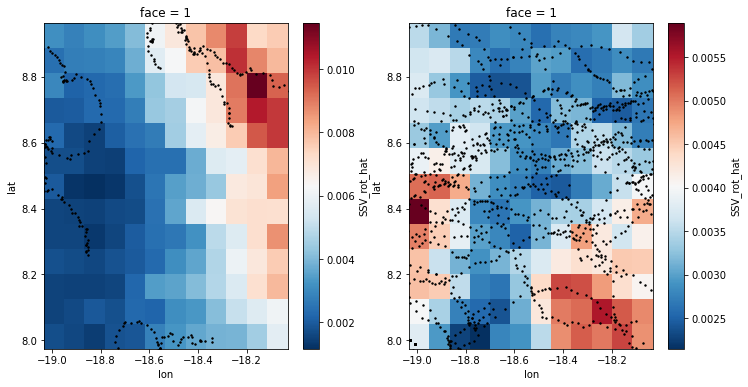

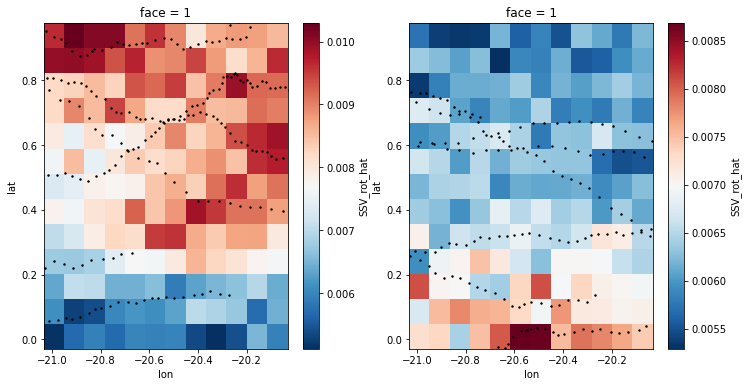

In [70]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
((ds_low_month0.SSV_rot_hat)**2).mean('time').plot(ax=ax[0],cmap='RdBu_r')
ax[0].scatter(month0.lon,month0.lat,s=2,c='k')
((ds_low_month1.SSV_rot_hat)**2).mean('time').plot(ax=ax[1],cmap='RdBu_r')
ax[1].scatter(month1.lon,month1.lat,s=2,c='k')

fig,ax = plt.subplots(1,2,figsize=(12,6))
((ds1_low_month0.SSV_rot_hat)**2).mean('time').plot(ax=ax[0],cmap='RdBu_r')
ax[0].scatter(month0.lon,month0.lat,s=2,c='k')
((ds1_low_month1.SSV_rot_hat)**2).mean('time').plot(ax=ax[1],cmap='RdBu_r')
ax[1].scatter(month1.lon,month1.lat,s=2,c='k')


In [72]:
_f,_ds = get_month(dsi_low,_df_sub,'2012-04')

In [189]:
print(df_mean.lon_bin.values-ds_mean.lon_bin.values)

[ 0.00000000e+00 -3.55271368e-15 -3.55271368e-15 -3.55271368e-15
 -7.10542736e-15 -7.10542736e-15 -1.06581410e-14 -1.06581410e-14
 -1.06581410e-14 -1.42108547e-14 -1.42108547e-14 -1.77635684e-14
 -1.77635684e-14 -1.77635684e-14 -2.13162821e-14 -2.13162821e-14
 -2.48689958e-14 -2.48689958e-14 -2.48689958e-14 -2.84217094e-14
 -2.84217094e-14 -3.19744231e-14 -3.19744231e-14 -3.19744231e-14
 -3.55271368e-14 -3.55271368e-14 -3.90798505e-14 -3.90798505e-14
 -3.90798505e-14 -4.26325641e-14 -4.26325641e-14 -4.61852778e-14
 -4.61852778e-14 -4.61852778e-14 -4.97379915e-14 -4.97379915e-14
 -5.32907052e-14 -5.32907052e-14 -5.32907052e-14 -5.68434189e-14
 -5.68434189e-14 -6.03961325e-14 -6.03961325e-14 -6.03961325e-14
 -6.39488462e-14 -6.39488462e-14 -6.75015599e-14 -6.75015599e-14
 -6.75015599e-14 -7.10542736e-14 -7.10542736e-14 -7.46069873e-14
 -7.46069873e-14 -7.46069873e-14 -7.81597009e-14 -7.81597009e-14
 -8.17124146e-14 -8.17124146e-14 -8.17124146e-14 -8.52651283e-14
 -8.52651283e-14 -8.88178

In [186]:
xr.merge?

Signature:
xr.merge(
    objects: "Iterable[Union[('DataArray', 'CoercibleMapping')]]",
    compat: 'str' = 'no_conflicts',
    join: 'str' = 'outer',
    fill_value: 'object' = <NA>,
    combine_attrs: 'str' = 'override',
) -> "'Dataset'"
Docstring:
Merge any number of xarray objects into a single Dataset as variables.

Parameters
----------
objects : iterable of Dataset or iterable of DataArray or iterable of dict-like
    Merge together all variables from these objects. If any of them are
    DataArray objects, they must have a name.
compat : {"identical", "equals", "broadcast_equals", "no_conflicts", "override"}, optional
    String indicating how to compare variables of the same name for
    potential conflicts:

    - "broadcast_equals": all values must be equal when variables are
      broadcast against each other to ensure common dimensions.
    - "equals": all values and dimensions must be the same.
    - "identical": all values, dimensions and attributes must be the
      sam

In [191]:
print(ds_mean,df_mean.energy_SSU)
#(df_mean.energy_SSU/ds_mean)
_mean = xr.merge([df_mean.energy_SSU,ds_mean],join='override')

<xarray.DataArray 'histogram_lon_lat' (lon_bin: 148, lat_bin: 100)>
array([[0.19001229, 0.20429107, 0.23641982, ..., 0.00326889, 0.00281756,
        0.0044619 ],
       [0.19000686, 0.2081063 , 0.23824181, ..., 0.00313184, 0.00411067,
        0.00505961],
       [0.1895037 , 0.22056935, 0.23671059, ..., 0.00371045, 0.00402954,
        0.0047395 ],
       ...,
       [0.32323087, 0.32075971, 0.31877424, ..., 0.00451339, 0.00481337,
        0.0048704 ],
       [0.32248233, 0.31984366, 0.32236028, ..., 0.00400469, 0.00427705,
        0.00358375],
       [0.32357104, 0.32726826, 0.3187217 , ..., 0.0041258 , 0.00408748,
        0.00291853]])
Coordinates:
  * lon_bin  (lon_bin) float64 -29.95 -29.85 -29.75 ... -15.45 -15.35 -15.25
  * lat_bin  (lat_bin) float64 0.05 0.15 0.25 0.35 0.45 ... 9.65 9.75 9.85 9.95 <xarray.DataArray 'energy_SSU' (lon_bin: 148, lat_bin: 100)>
array([[0.21521766, 0.14098556, 0.29185224, ..., 0.00756151,        nan,
               nan],
       [0.19380137, 0.18500342

In [192]:
_mean

<xarray.Dataset>
Dimensions:            (lon_bin: 148, lat_bin: 100)
Coordinates:
  * lon_bin            (lon_bin) float64 -29.95 -29.85 -29.75 ... -15.35 -15.25
  * lat_bin            (lat_bin) float64 0.05 0.15 0.25 0.35 ... 9.75 9.85 9.95
Data variables:
    energy_SSU         (lon_bin, lat_bin) float64 0.2152 0.141 ... 0.005481
    histogram_lon_lat  (lon_bin, lat_bin) float64 0.19 0.2043 ... 0.002919

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


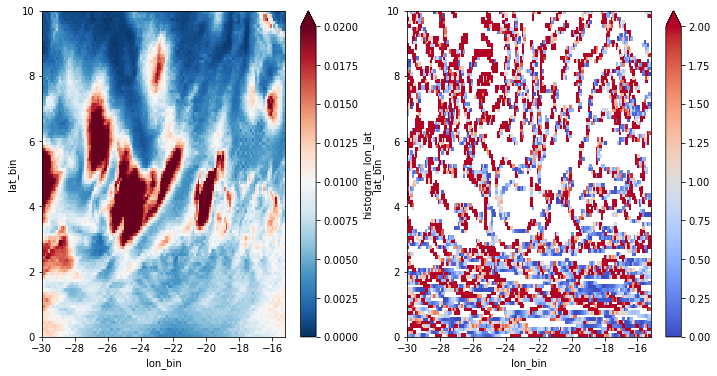

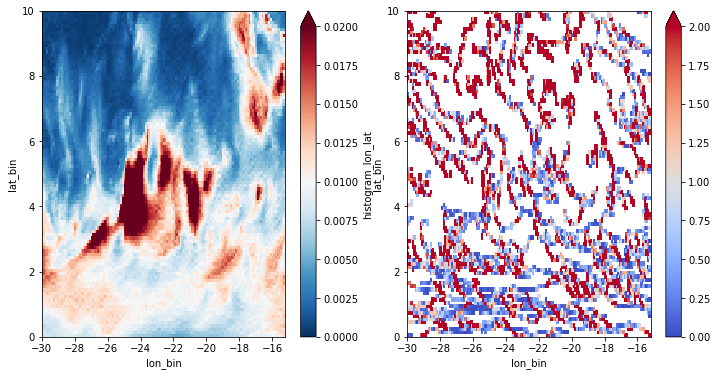

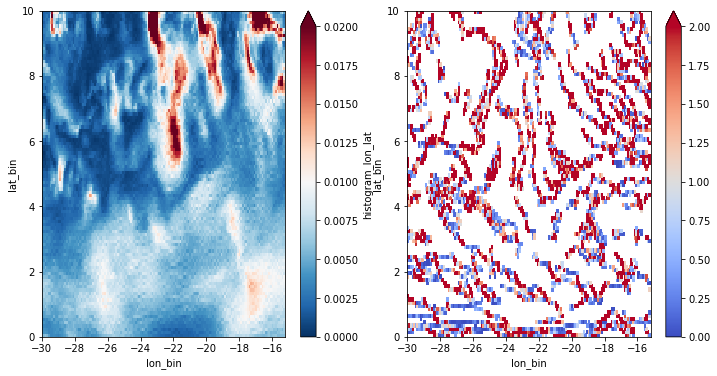

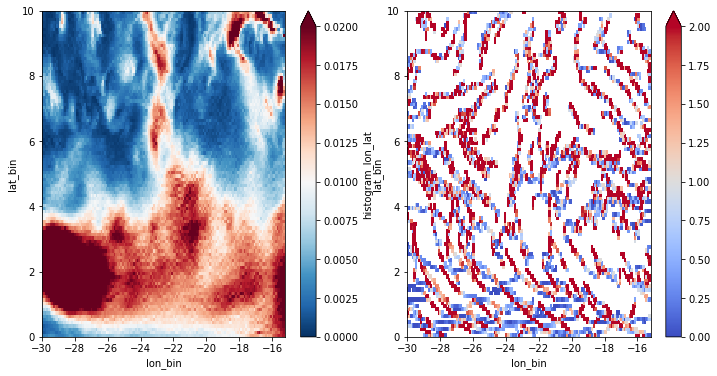

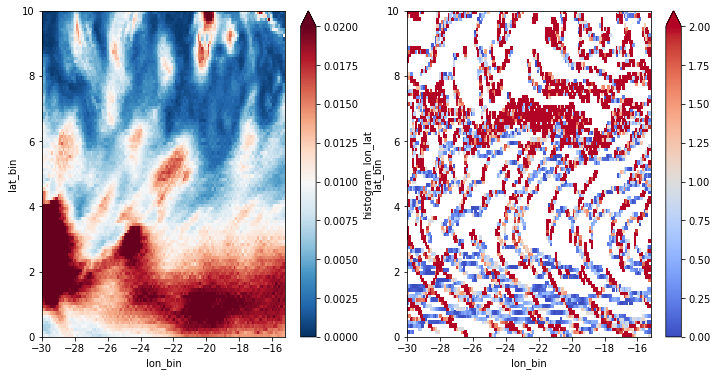

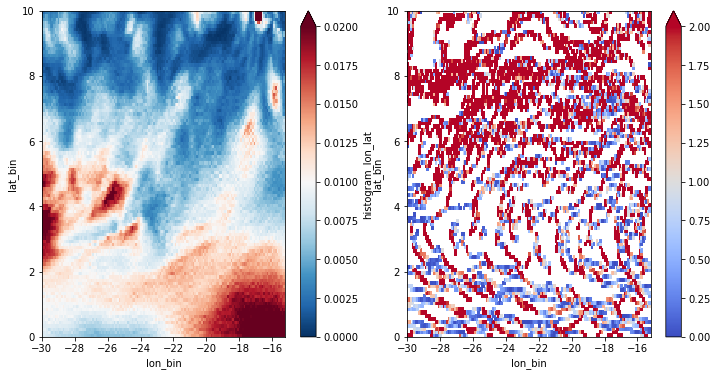

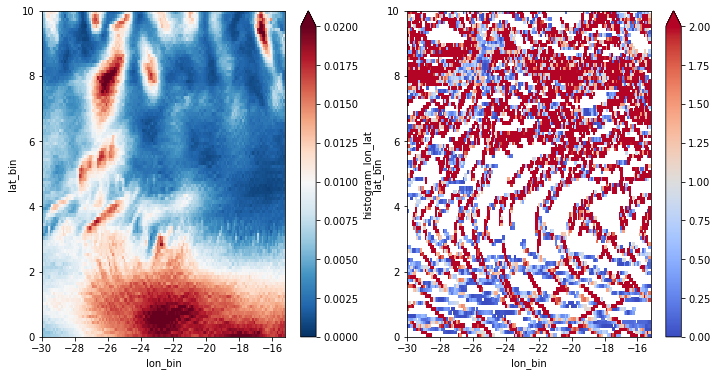

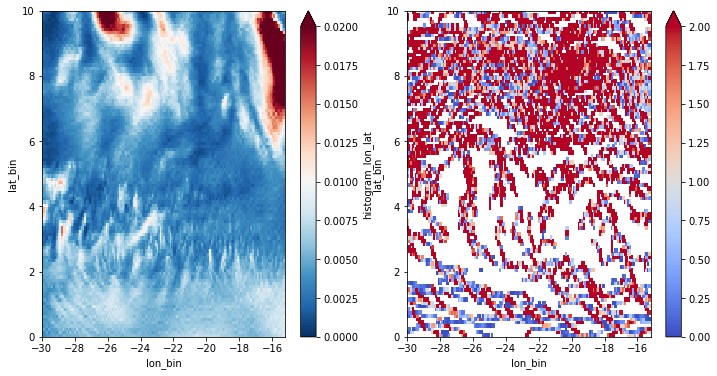

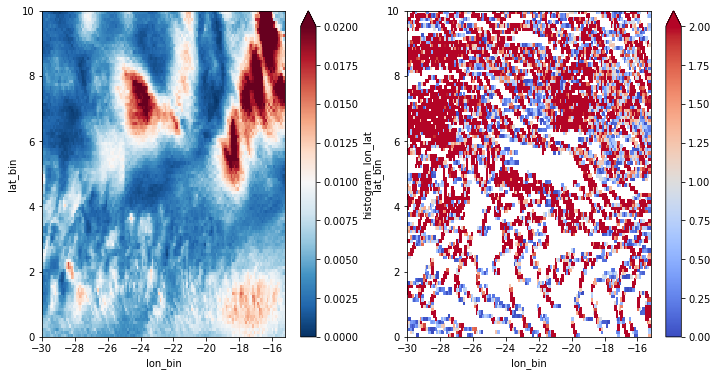

In [199]:
for i in ['2011-12','2012-01','2012-03','2012-04','2012-05','2012-06','2012-07','2012-08','2012-09']:
    df_mean, ds_mean = binned_month(ds_low,_df,i,'energy_SSV')
    _f,_ds = get_month(dsi_low,_df_sub,i)
    _nb = nb_month(_f)
    _mean = xr.merge([ds_mean.rename('E_energy_SSV'),df_mean.energy_SSV],join='override')
    fig, ax =  plt.subplots(1,2,figsize=(12,6))
    ds_mean.plot(y='lat_bin',ax=ax[0],vmax=0.02,vmin=0,cmap='RdBu_r')
    (_mean.energy_SSV/_mean.E_energy_SSV).plot(y='lat_bin',ax=ax[1],vmax=2,vmin=0,cmap='coolwarm')

/dev/shm/pbs.441390.datarmor0/ipykernel_48676/4098216938.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,2,figsize=(12,6))


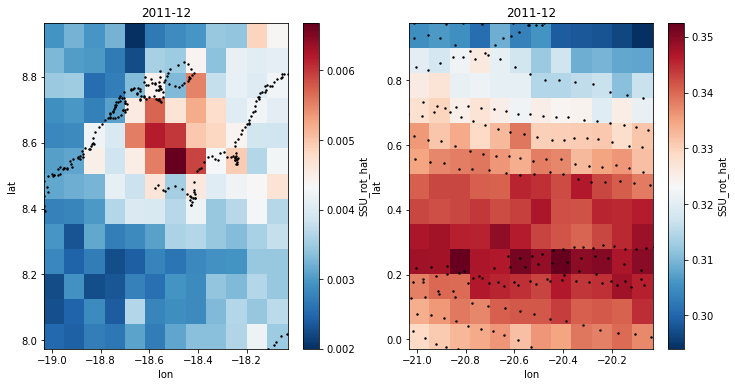

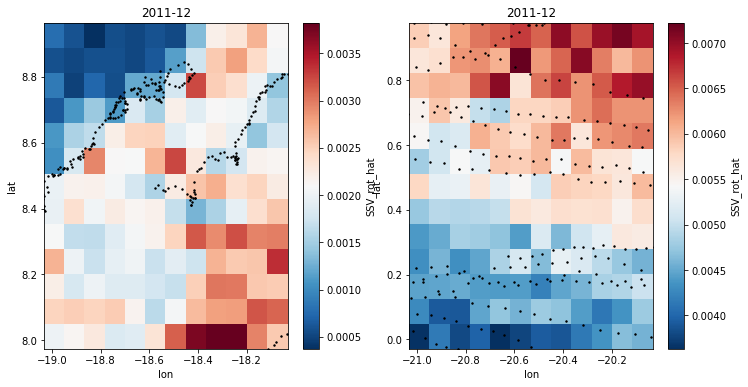

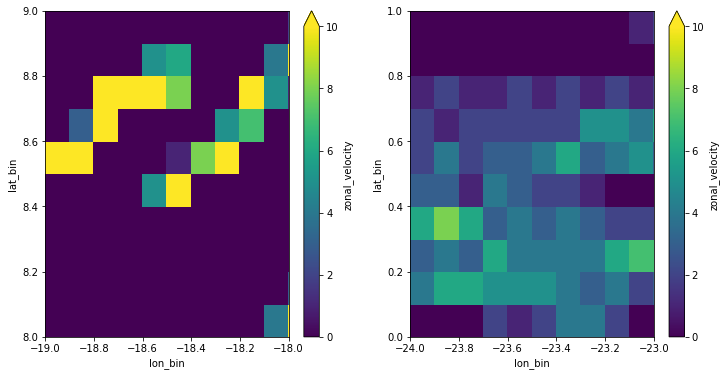

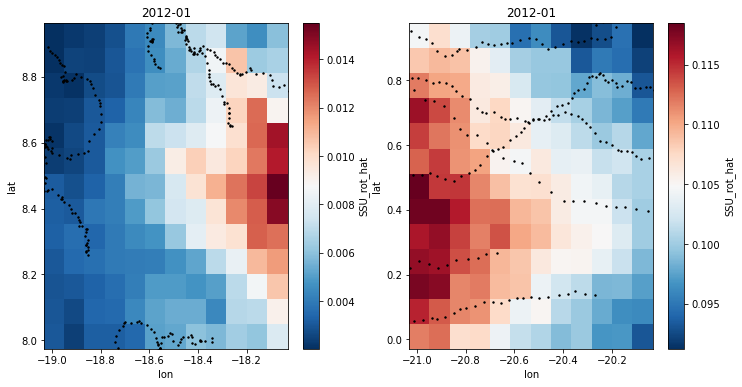

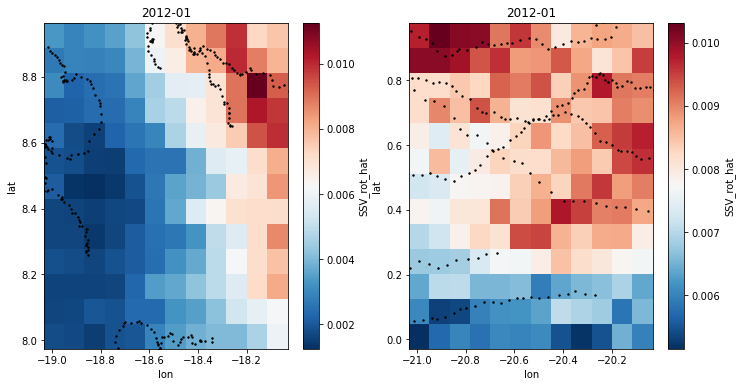

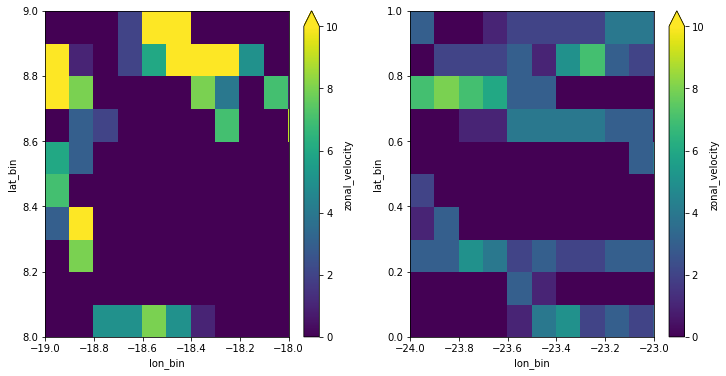

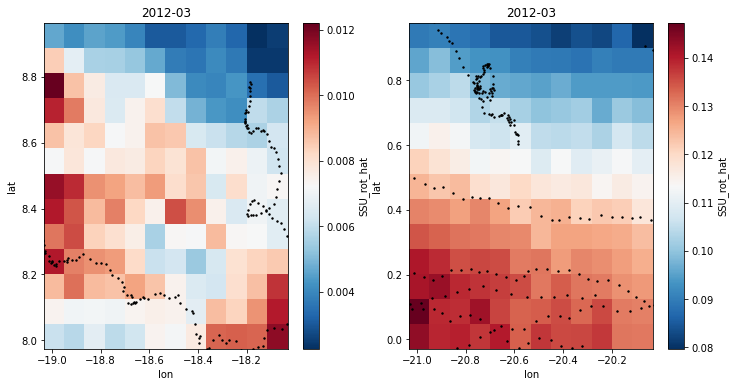

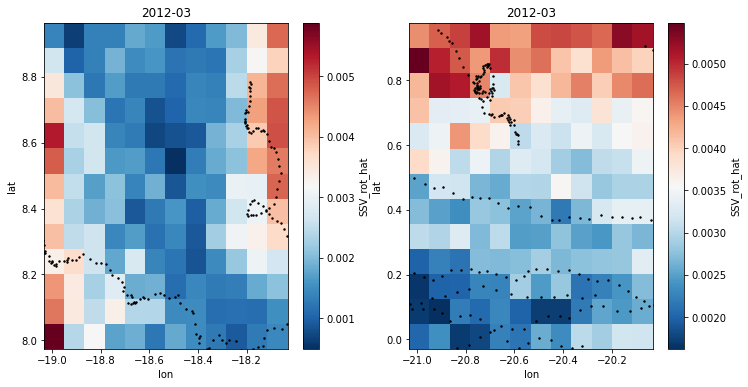

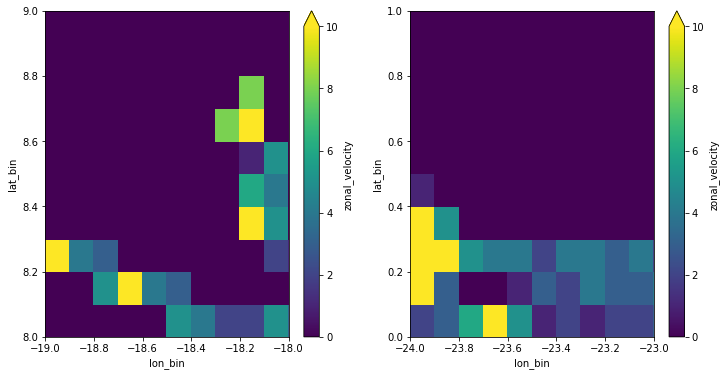

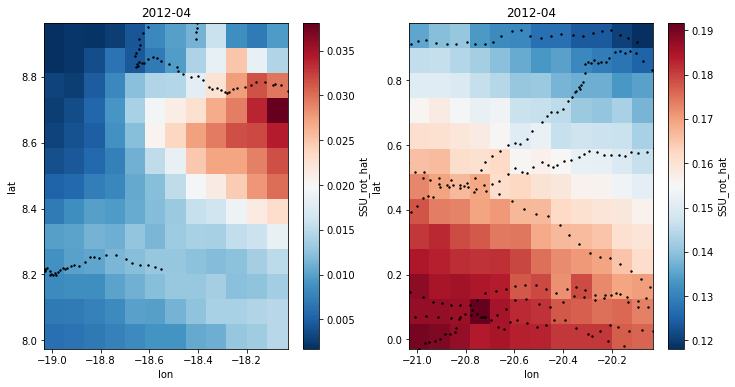

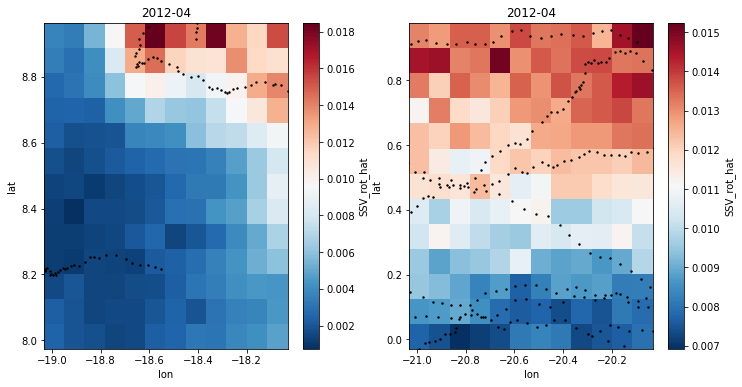

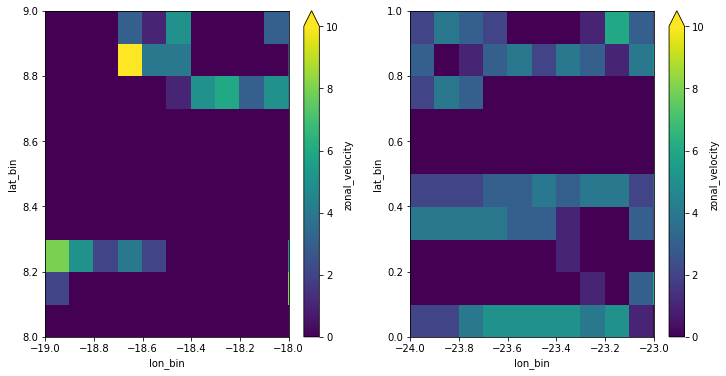

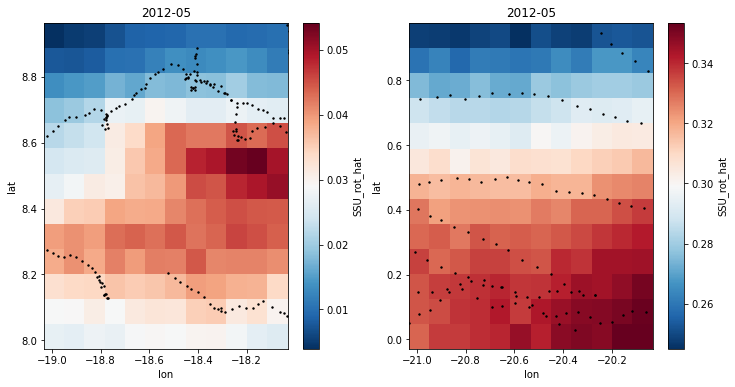

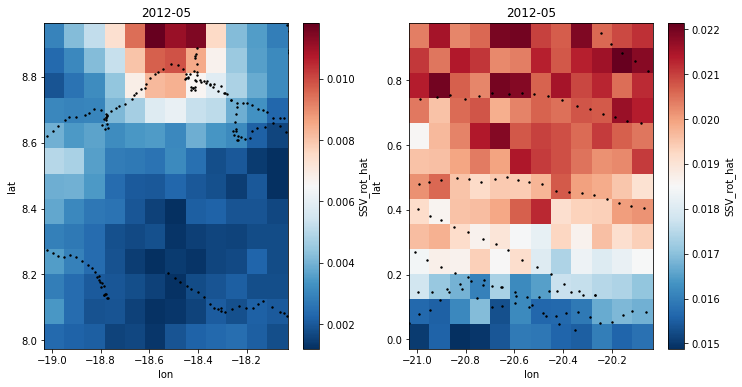

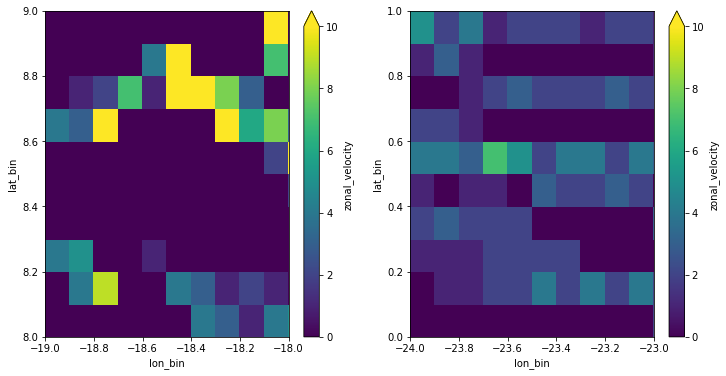

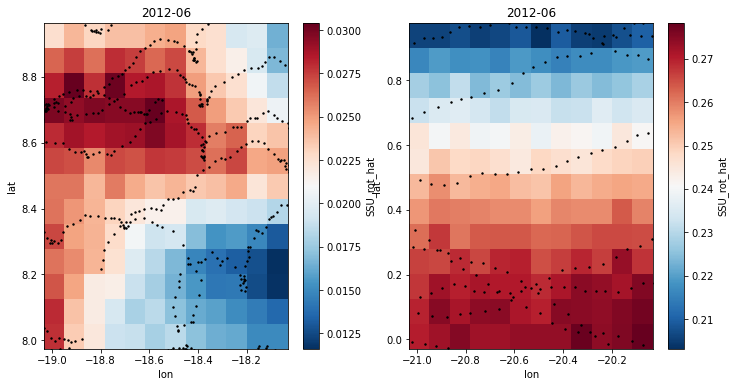

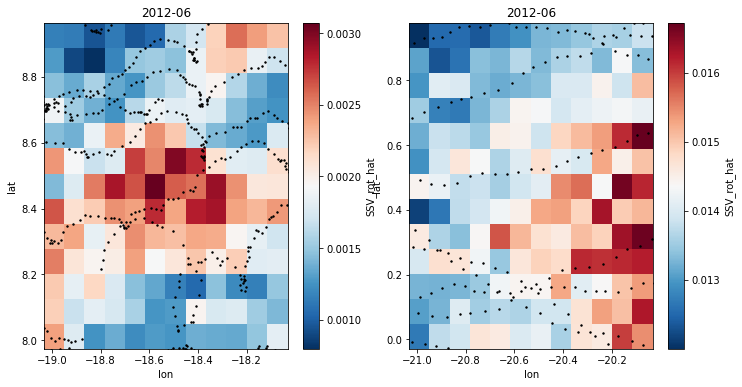

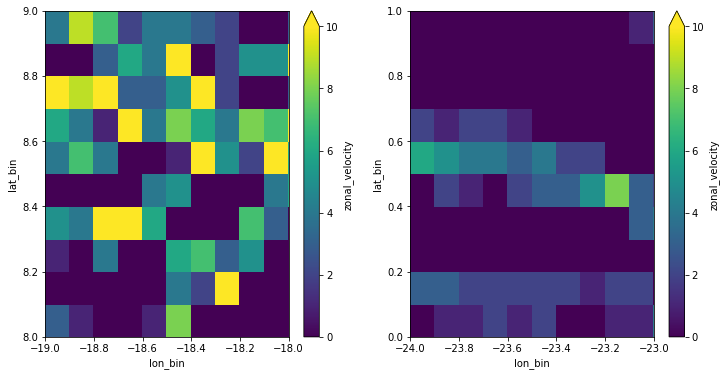

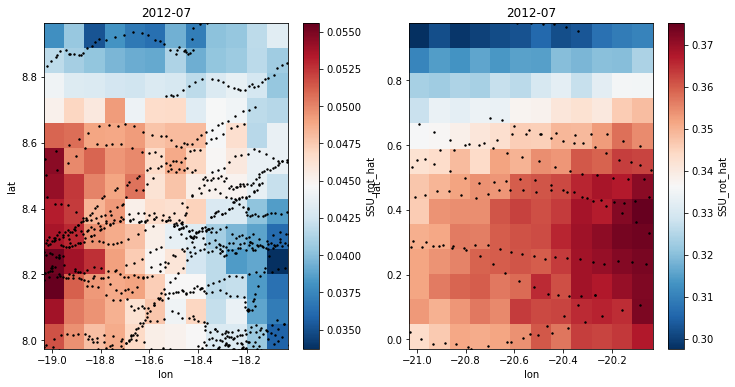

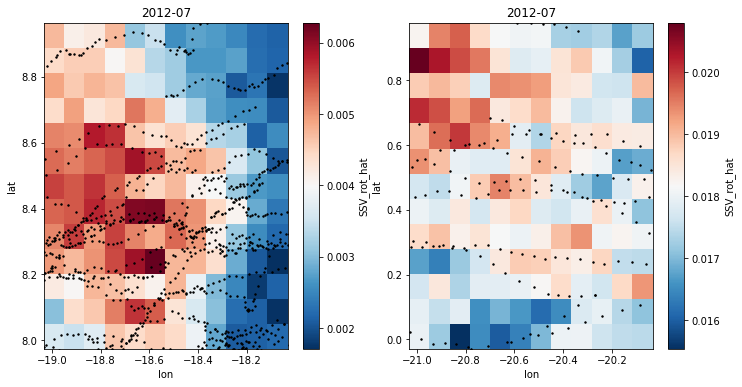

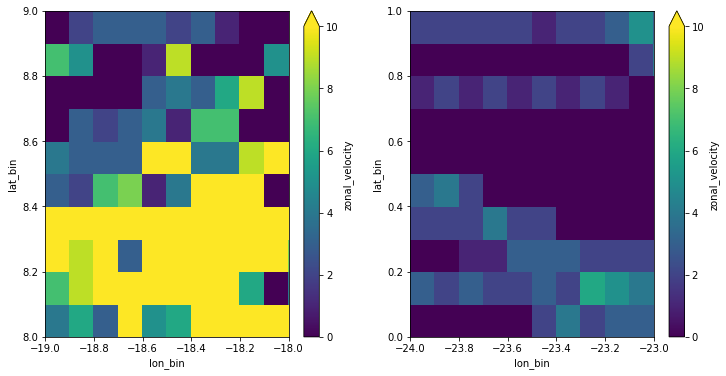

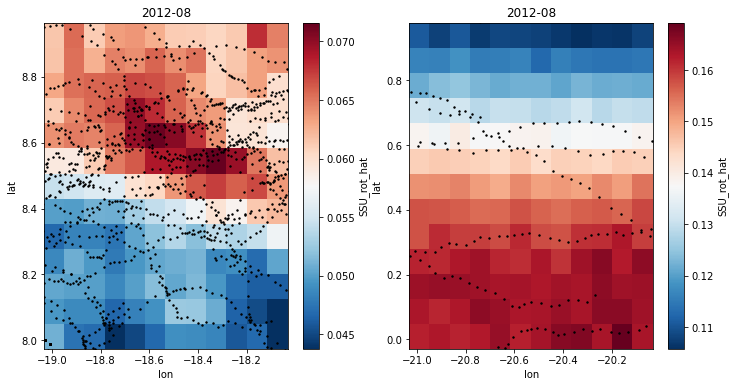

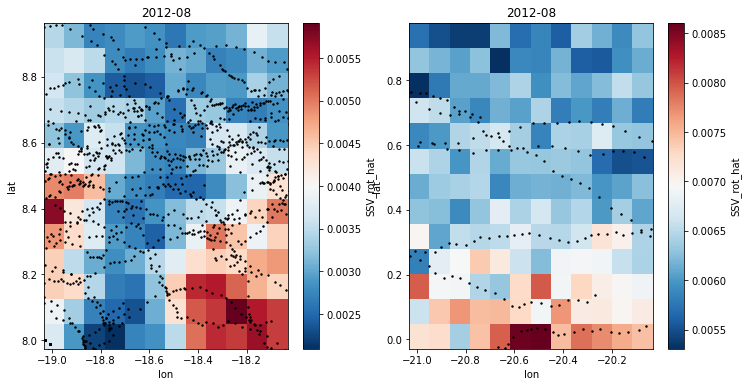

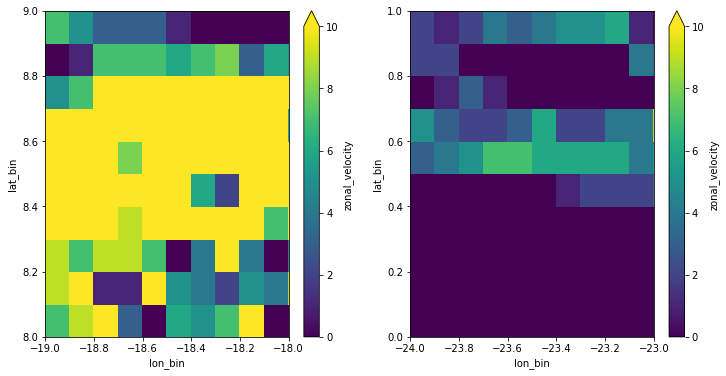

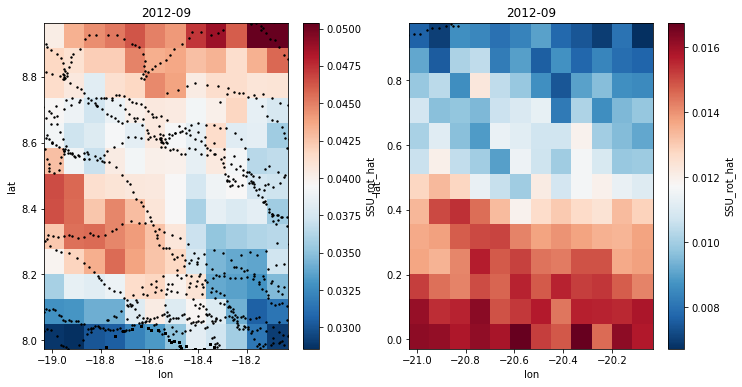

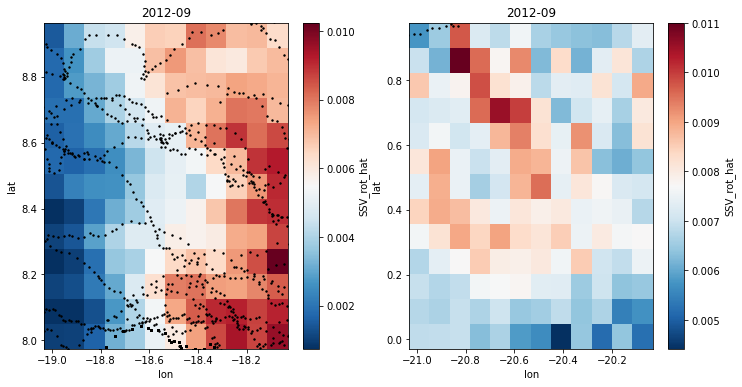

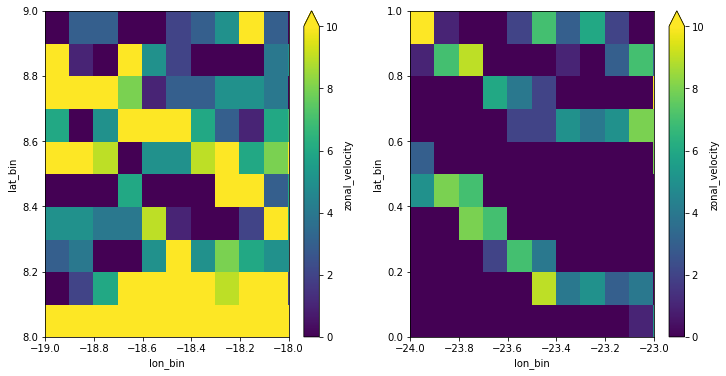

In [73]:
for i in ['2011-12','2012-01','2012-03','2012-04','2012-05','2012-06','2012-07','2012-08','2012-09']:
    _f,_ds0 = get_month(dsi_low,_df_sub,i)
    _f,_ds1 = get_month(dsi_low_1,_df_sub,i)
    _nb = nb_month(_f)
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    ((_ds0.SSU_rot_hat)**2).mean('time').plot(ax=ax[0],cmap='RdBu_r')
    ax[0].scatter(_f.lon,_f.lat,s=2,c='k');
    ax[0].set_title(i);
    ((_ds1.SSU_rot_hat)**2).mean('time').plot(ax=ax[1],cmap='RdBu_r')
    ax[1].scatter(_f.lon,_f.lat,s=2,c='k');ax[1].set_title(i);
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    ((_ds0.SSV_rot_hat)**2).mean('time').plot(ax=ax[0],cmap='RdBu_r')
    ax[0].scatter(_f.lon,_f.lat,s=2,c='k');
    ax[0].set_title(i);
    ((_ds1.SSV_rot_hat)**2).mean('time').plot(ax=ax[1],cmap='RdBu_r')
    ax[1].scatter(_f.lon,_f.lat,s=2,c='k');ax[1].set_title(i);
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    _nb.zonal_velocity.plot(ax=ax[0],vmax=10,y='lat_bin',xlim=(-19,-18),ylim=(8,9))
    _nb.zonal_velocity.plot(ax=ax[1],vmax=10,y='lat_bin',xlim=(-24,-23),ylim=(0,1))

/dev/shm/pbs.441390.datarmor0/ipykernel_48676/1932553172.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,2,figsize=(12,6))


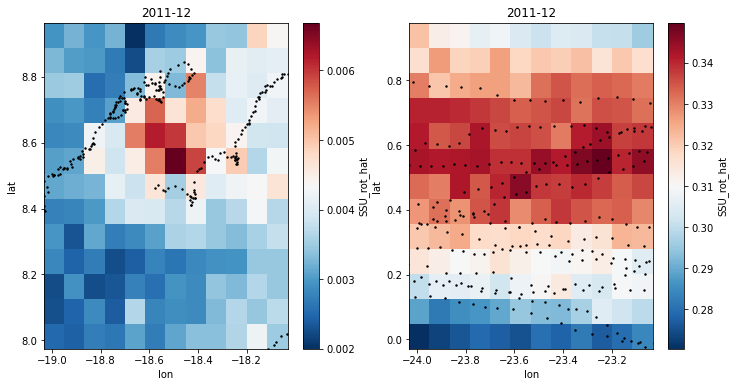

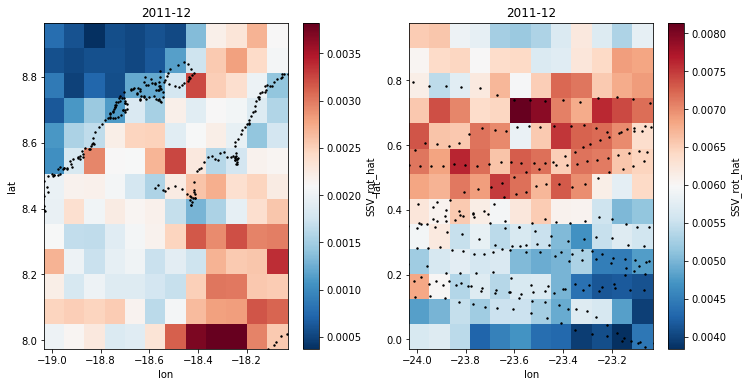

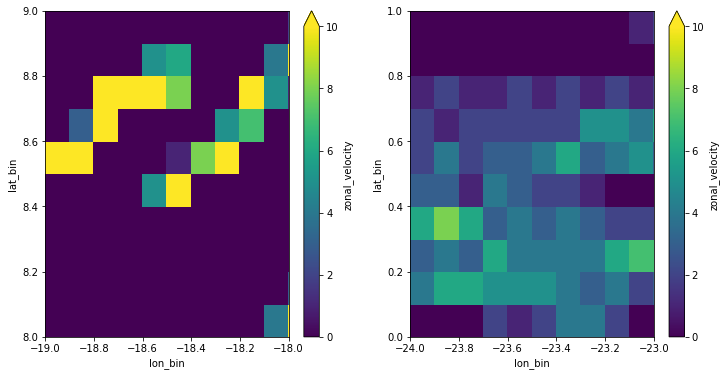

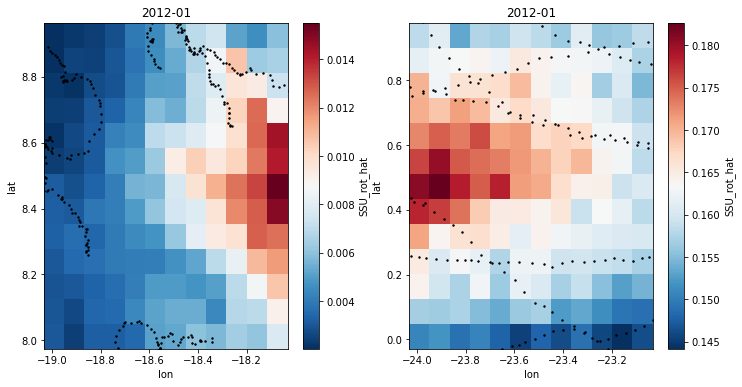

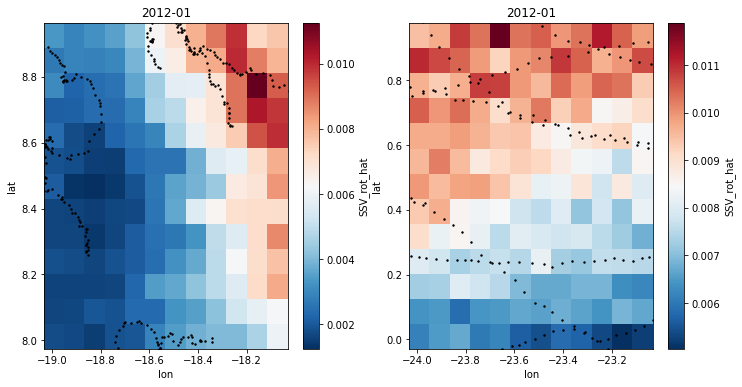

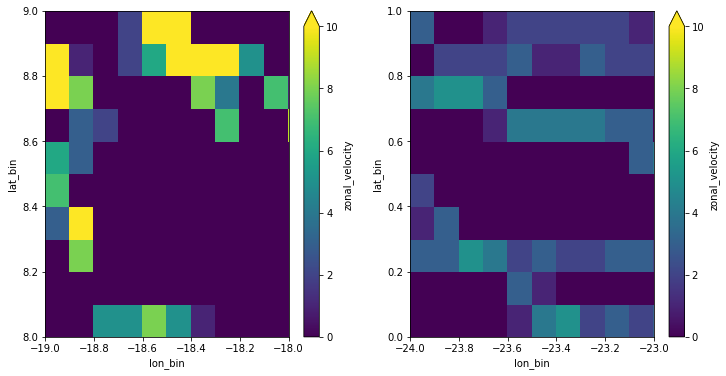

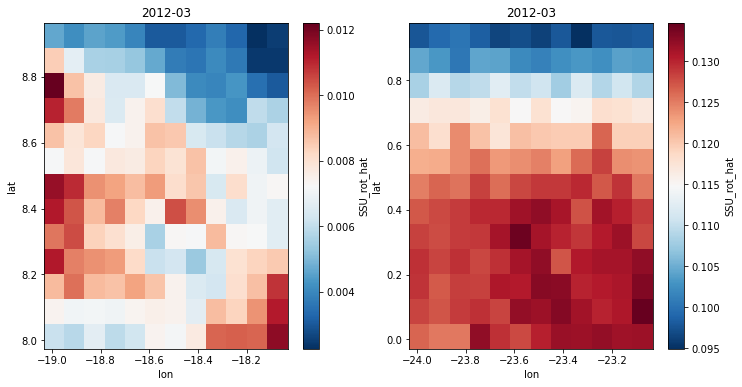

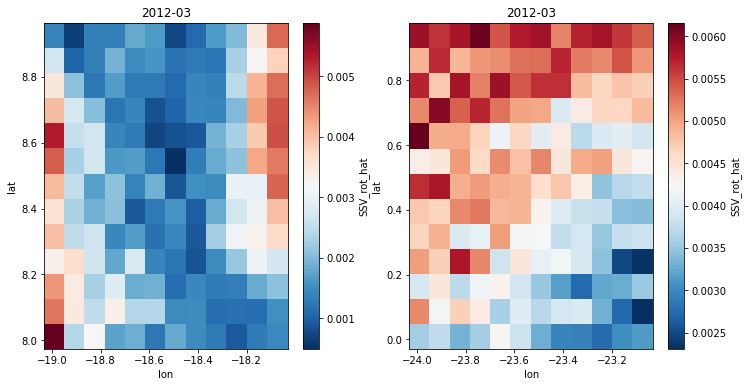

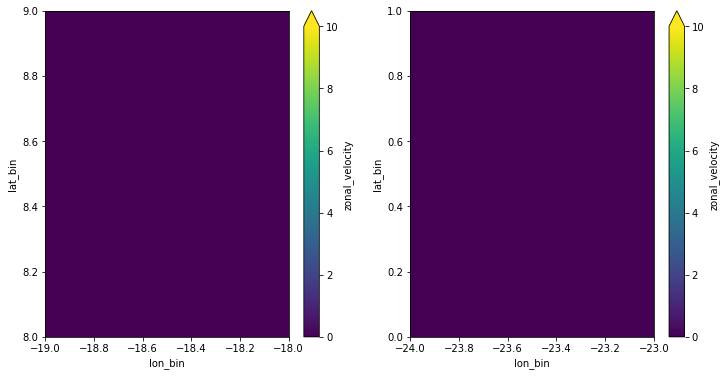

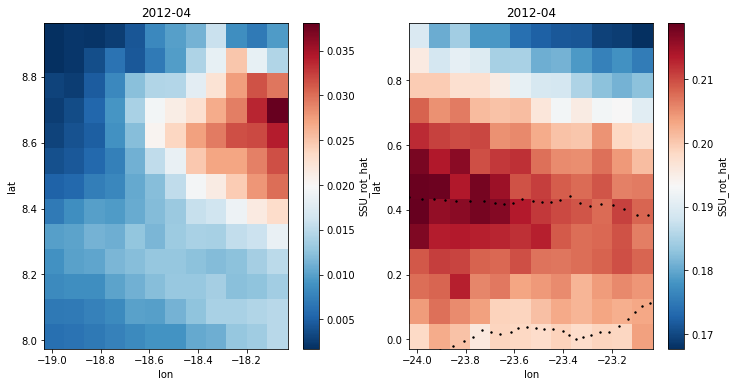

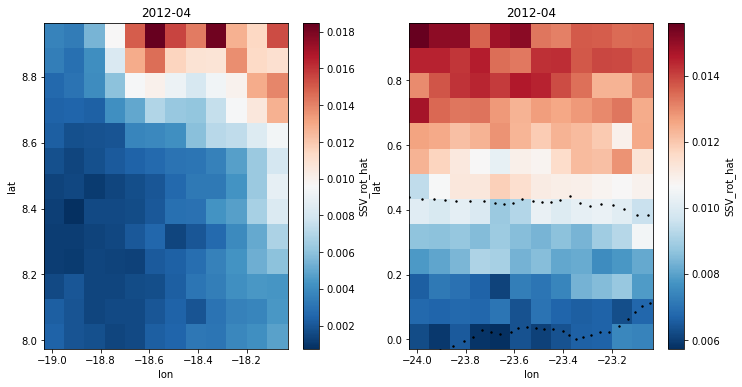

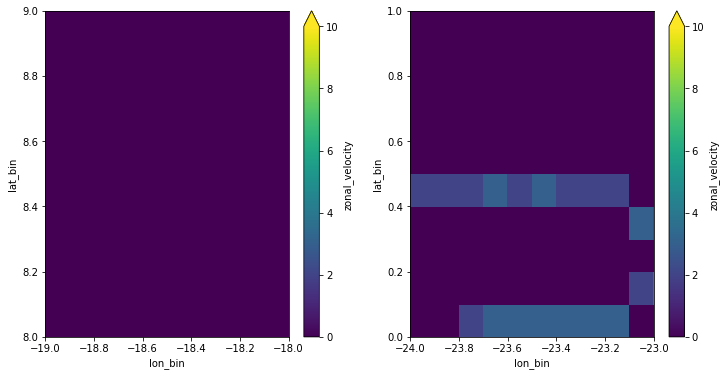

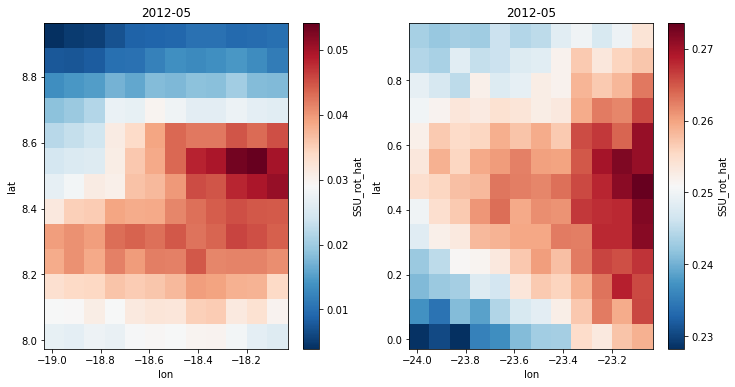

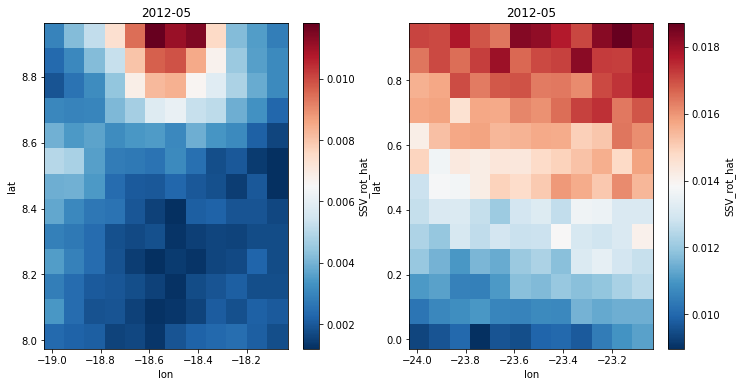

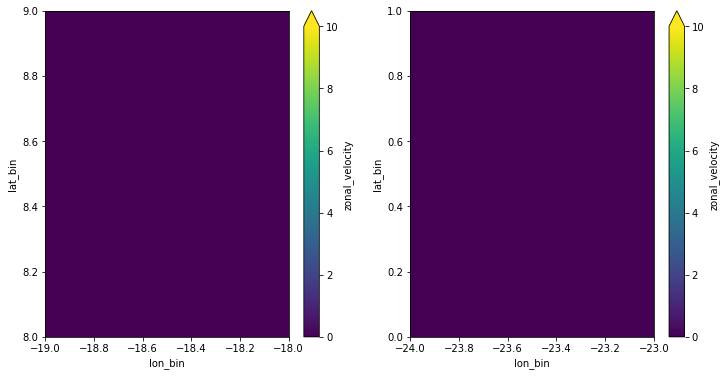

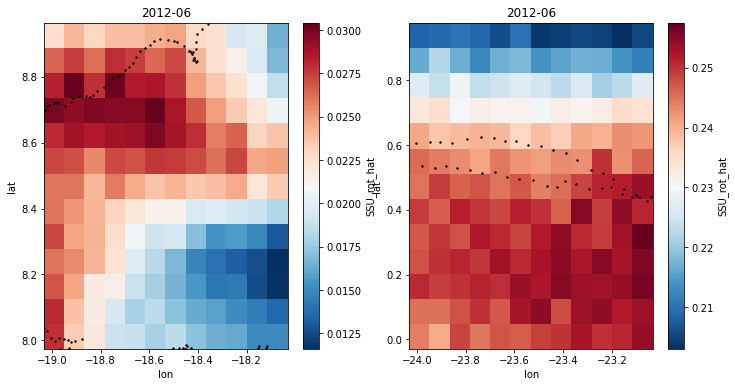

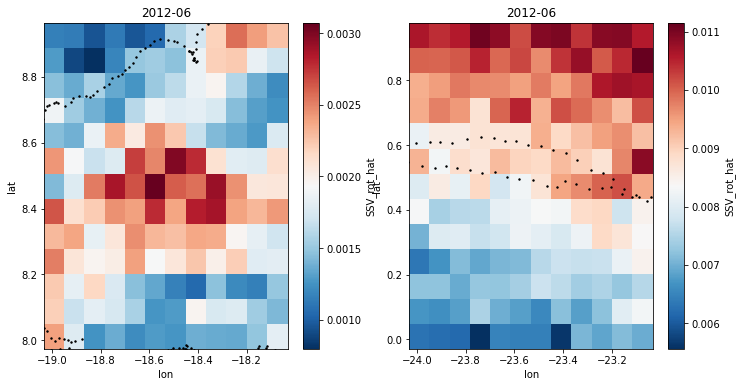

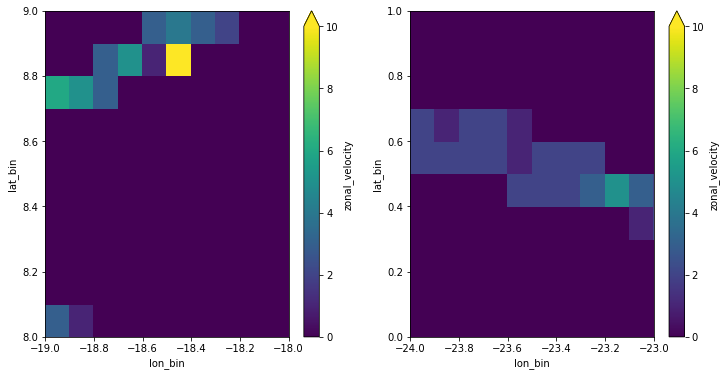

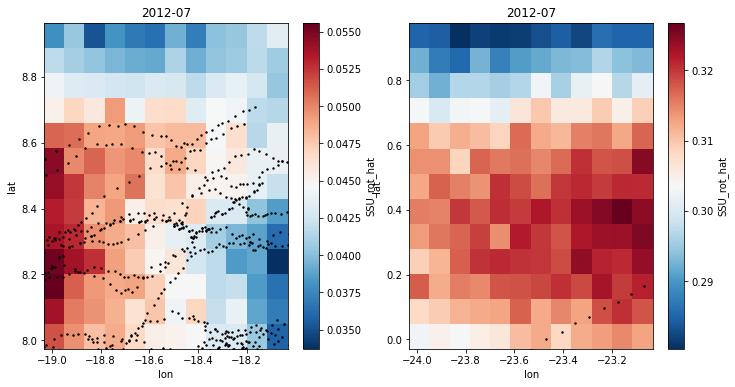

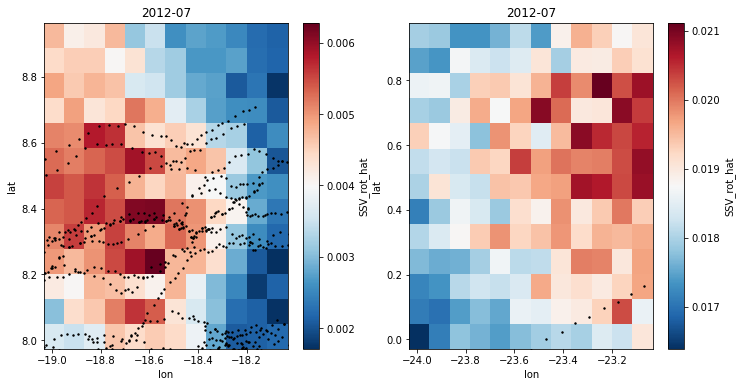

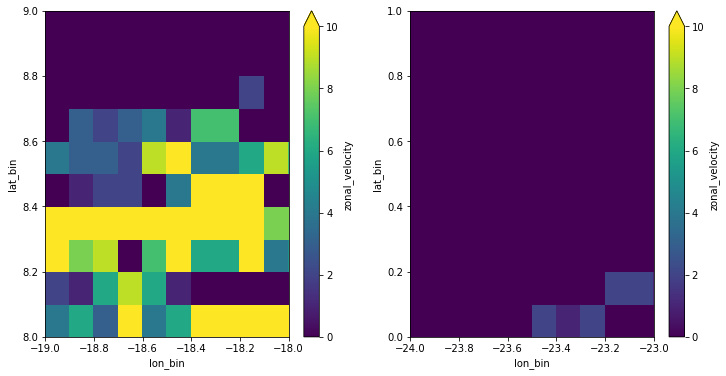

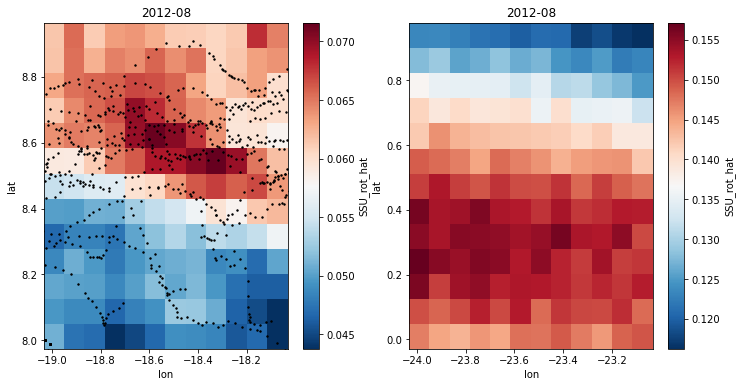

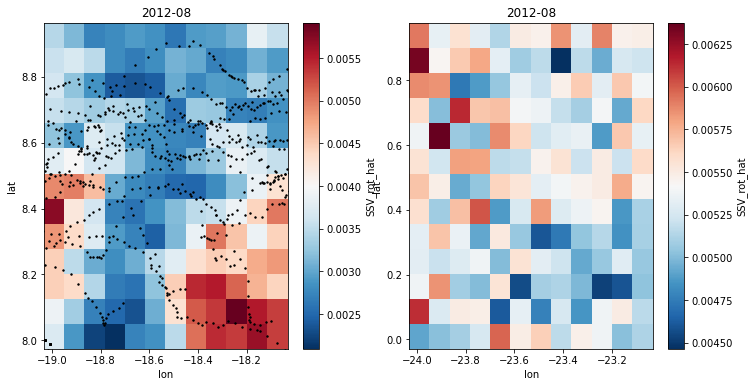

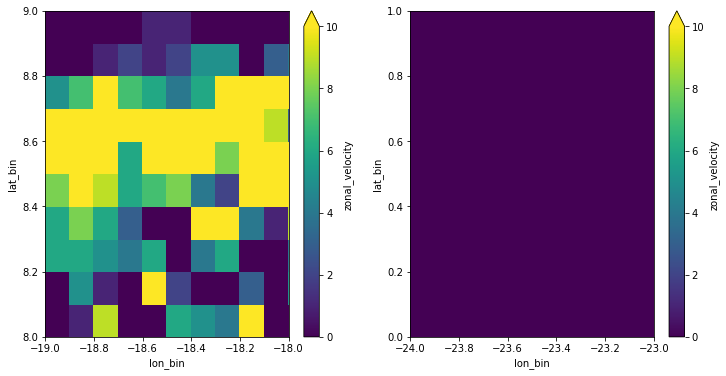

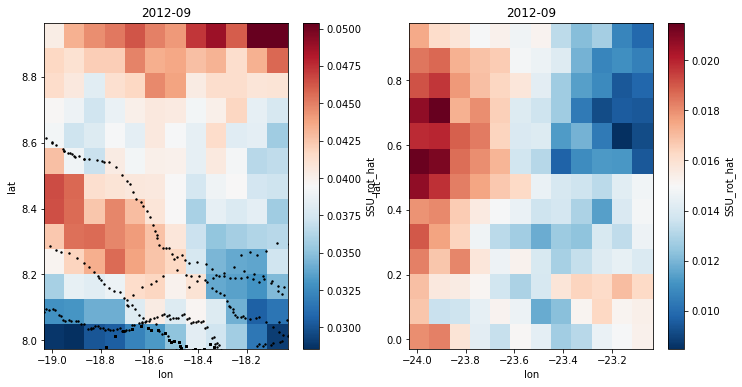

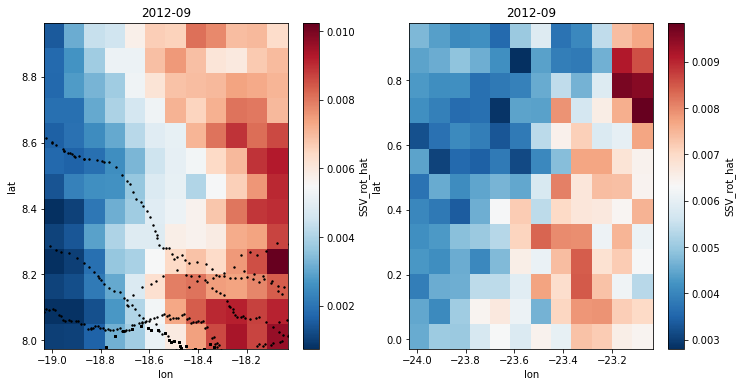

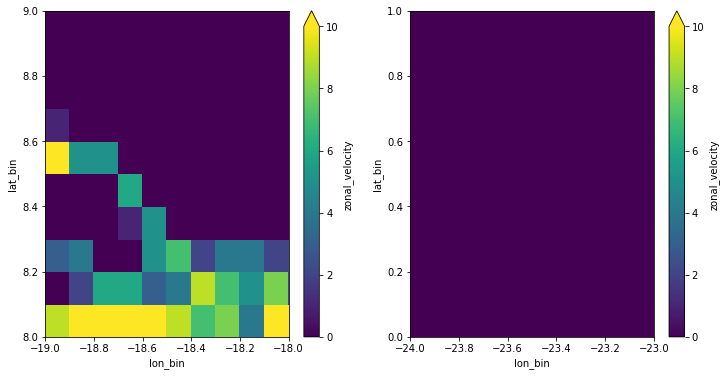

In [55]:
for i in ['2011-12','2012-01','2012-03','2012-04','2012-05','2012-06','2012-07','2012-08','2012-09']:
    _f,_ds0 = get_month(dsi_low,df_sub0,i)
    _f,_ds1 = get_month(dsi_low_1,df_sub0,i)
    _nb = nb_month(_f)
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    ((_ds0.SSU_rot_hat)**2).mean('time').plot(ax=ax[0],cmap='RdBu_r')
    ax[0].scatter(_f.lon,_f.lat,s=2,c='k');
    ax[0].set_title(i);
    ((_ds1.SSU_rot_hat)**2).mean('time').plot(ax=ax[1],cmap='RdBu_r')
    ax[1].scatter(_f.lon,_f.lat,s=2,c='k');ax[1].set_title(i);
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    ((_ds0.SSV_rot_hat)**2).mean('time').plot(ax=ax[0],cmap='RdBu_r')
    ax[0].scatter(_f.lon,_f.lat,s=2,c='k');
    ax[0].set_title(i);
    ((_ds1.SSV_rot_hat)**2).mean('time').plot(ax=ax[1],cmap='RdBu_r')
    ax[1].scatter(_f.lon,_f.lat,s=2,c='k');ax[1].set_title(i);
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    _nb.zonal_velocity.plot(ax=ax[0],vmax=10,y='lat_bin',xlim=(-19,-18),ylim=(8,9))
    _nb.zonal_velocity.plot(ax=ax[1],vmax=10,y='lat_bin',xlim=(-24,-23),ylim=(0,1))

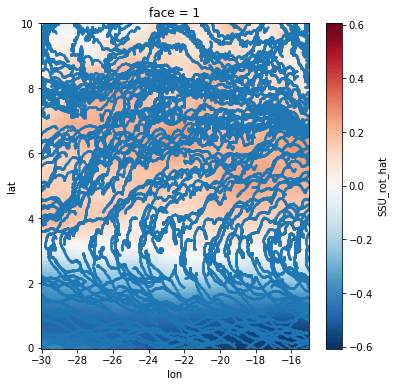

In [29]:
fig,ax = plt.subplots(figsize=(6,6))
ds_low.isel(time=slice(130*12,(130+30)*12)).SSU_rot_hat.mean('time').plot(ax=ax,x='lon',y='lat',cmap='RdBu_r')

_ = _df_sub.loc[time_sub[130*12:(130+30)*12]]
ax.scatter(_.lon,_.lat,s=2)

In [42]:
_df_sub.groupby('trajectory').count()

lat   lon  zonal_velocity  meridional_velocity  \
trajectory                                                    
5000947     2881  2881            2881                 2881   
5001022     2881  2881            2881                 2881   
5001047     2881  2881            2881                 2881   
5001070     2881  2881            2881                 2881   
5001119     2881  2881            2881                 2881   
...          ...   ...             ...                  ...   
46002869     641   641             641                  641   
46002873     641   641             641                  641   
46002876     641   641             641                  641   
46002877     641   641             641                  641   
46003013     481   481             481                  481   

            zonal_velocity_hat_real  meridional_velocity_hat_real  
trajectory                                                         
5000947                        2881                          2881  
5001022                        2881                          2881  
5001047                        2881                          2881  
5001070                        2881                          2881  
5001119                        2881                          2881  
...                             ...                           ...  
46002869                        641                           641  
46002873                        641                           641  
46002876                        641                           641  
46002877                        641                           641  
46003013                        481                           481  

[798 rows x 6 columns]

In [43]:
df_id = _df_sub.groupby('trajectory').get_group(5001119)

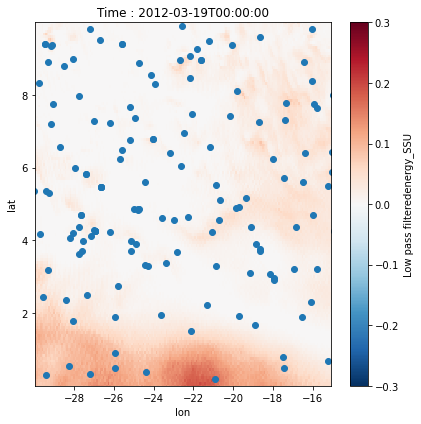

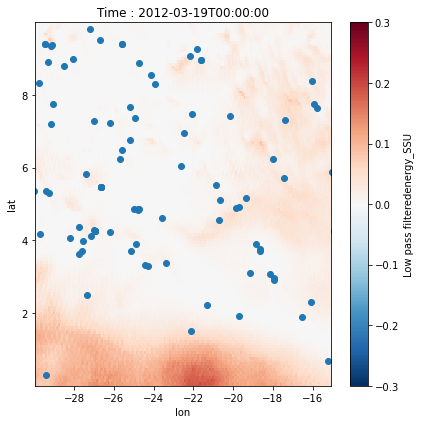

In [117]:
gen_fig_flts(ds_low,_df_sub,1000,'energy_SSU',savefig=False)

gen_fig_flts(ds_low,df_sub0,1000,'energy_SSU',savefig=False)

In [37]:
df_id = _df_sub.groupby('trajectory').get_group(5000947)

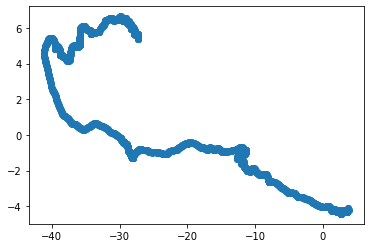

In [39]:
plt.scatter(df_id.lon,df_id.lat)

In [118]:
for it in range(0,ds_low.time.size,2):
    gen_fig_flts(ds_low,df_sub0,it,'SSV_rot',savefig=True)

In [8]:
ds_low.to_netcdf('/home1/datawork/zcaspar/mit4320/llc_SSU_low.nc')

In [200]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/